In [3]:
import numpy as np
import pylab as plt
from matplotlib import cm

In [4]:
def objective_function(x,y):
    return (x+y)*np.exp(-6*(x*x+y*y))

In [13]:
# https://w3.pppl.gov/~hammett/comp/python/koer.ioc.ee/man/pygraph/PyGist/PyGist_3D.mkr5.html
NL = 32
search_area_scale = 2
search_area_center = (0,0)
lX = np.arange(search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_scale/NL)
lY = np.arange(search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2,search_area_scale/NL)
X,Y = np.meshgrid(lX,lY)
Z = objective_function(X,Y)

X_min = X.ravel()[Z.argmin()]
Y_min = Y.ravel()[Z.argmin()]

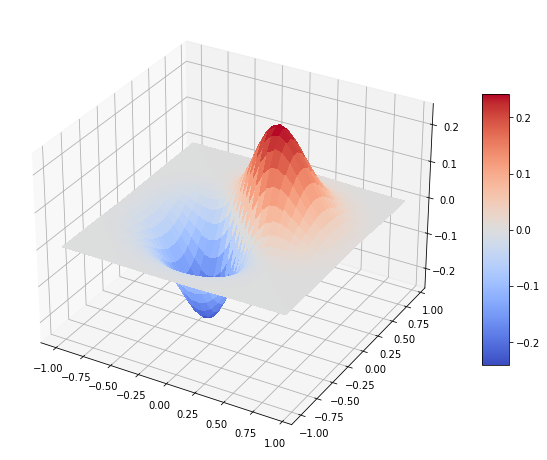

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

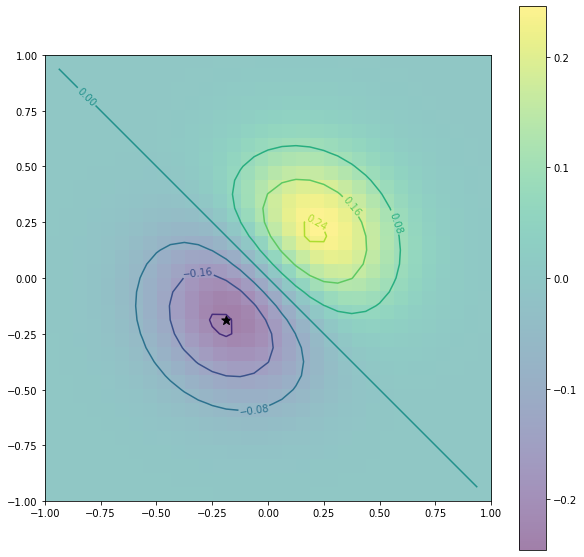

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
plt.imshow(Z, extent=[search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.scatter([X_min],[Y_min],marker='*',c='k',s=100)
plt.show()

We need a starting point and an area to start our search. x0 = (0,0) and a square of length L = 2 seems to be OK. We need the number of particles NP

In [21]:
NP = 10
v = 0.1
dt = 0.1
uP0 = np.random.uniform(-search_area_scale/2,search_area_scale/2.,size=(NP,2)) + search_area_center
vP0 = v*np.random.randn(NP,2)

In [22]:
uP0.shape, vP0.shape

((10, 2), (10, 2))

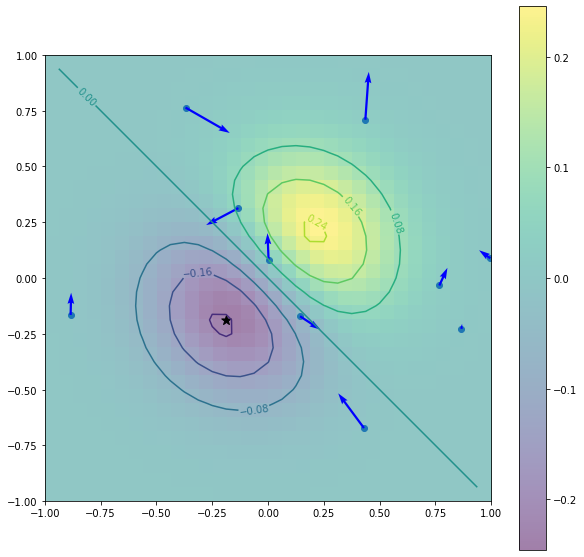

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
plt.imshow(Z, extent=[search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.scatter([X_min],[Y_min],marker='*',c='k',s=100)
plt.scatter(*(zip(*uP0)))
plt.quiver(*(zip(*uP0)),*(zip(*vP0)) , color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
plt.show()

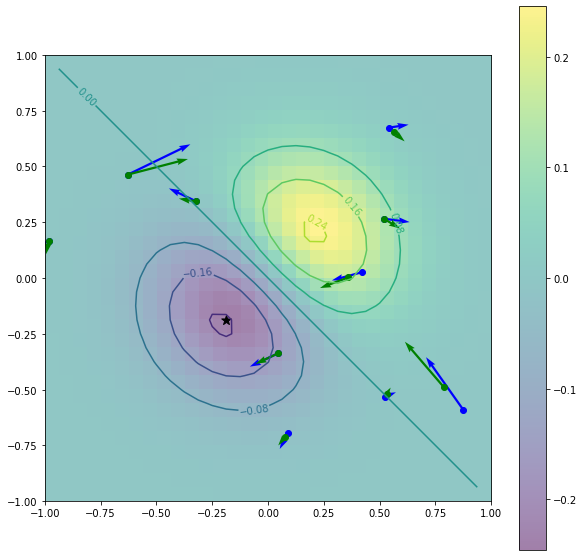

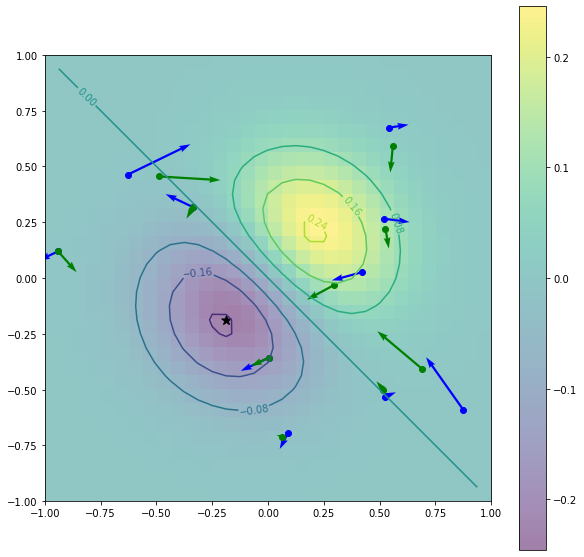

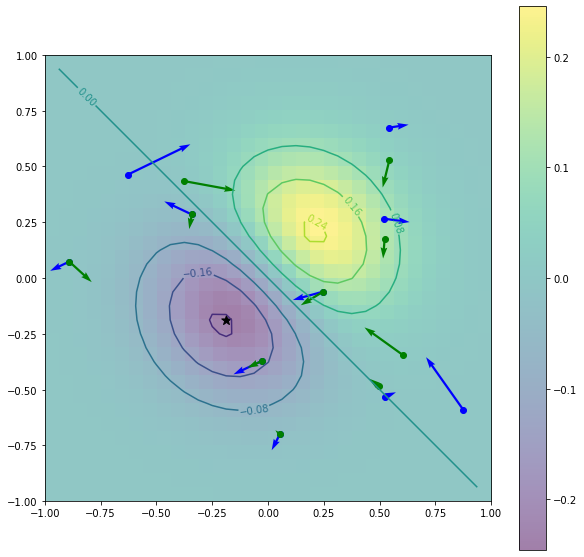

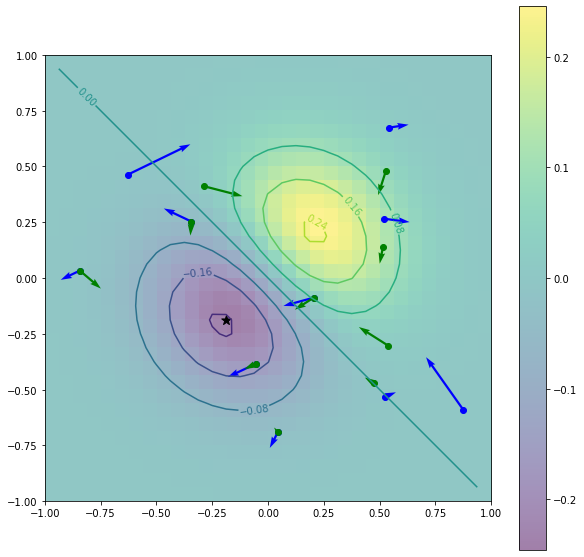

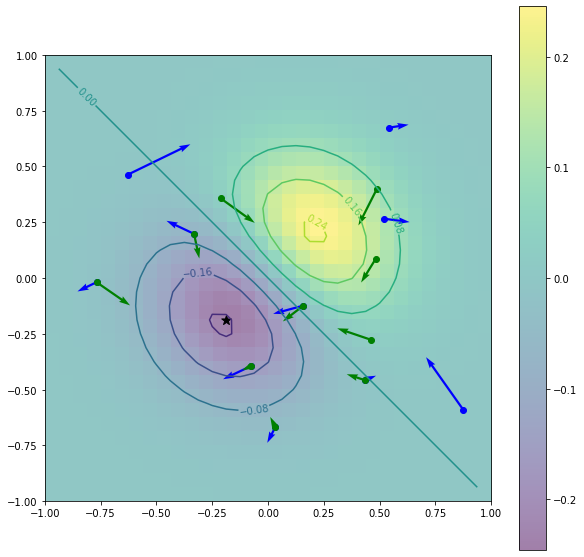

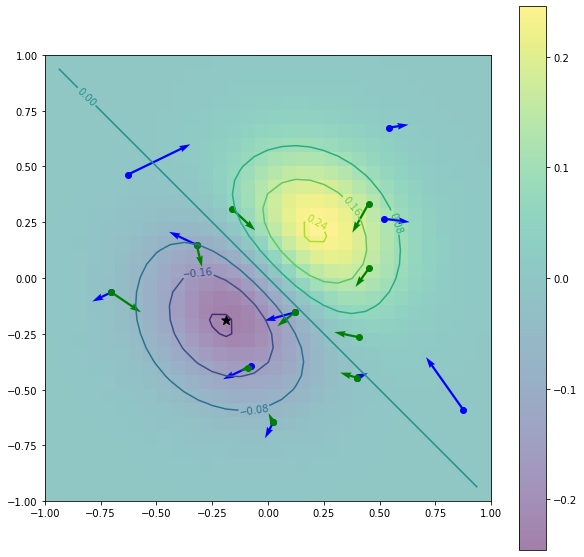

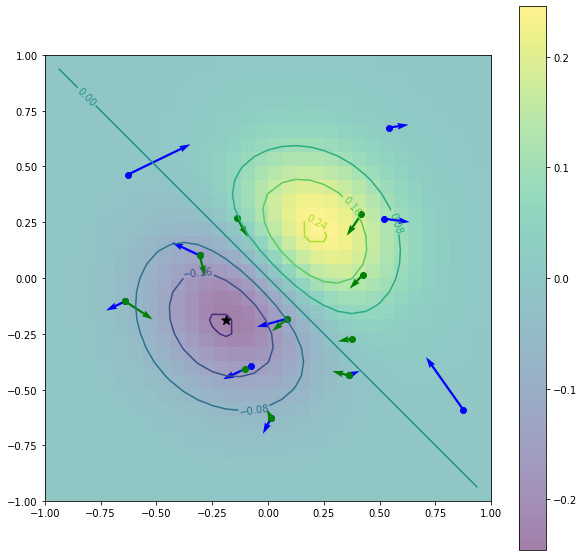

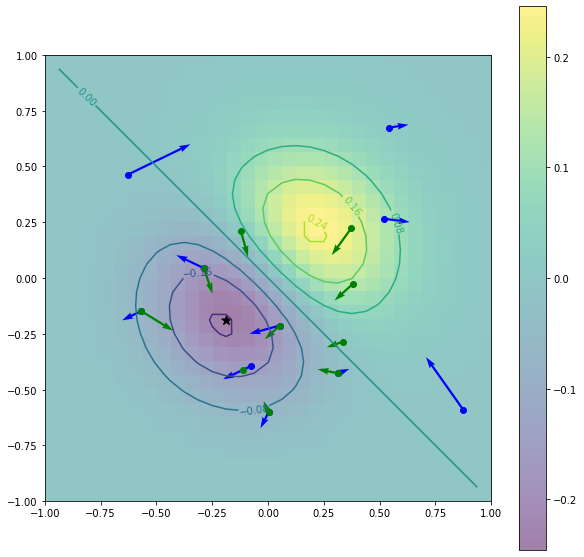

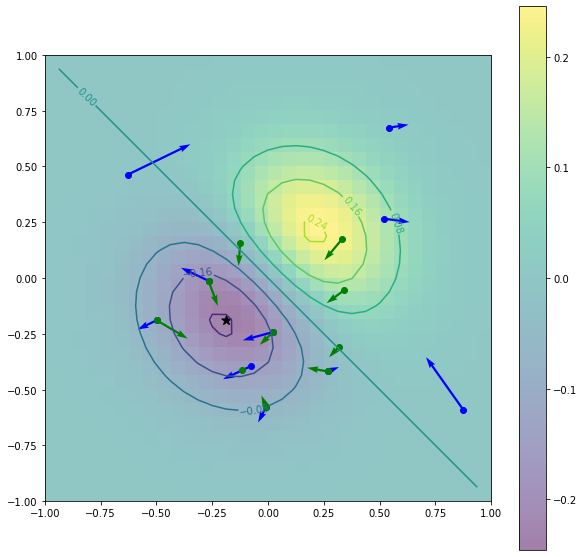

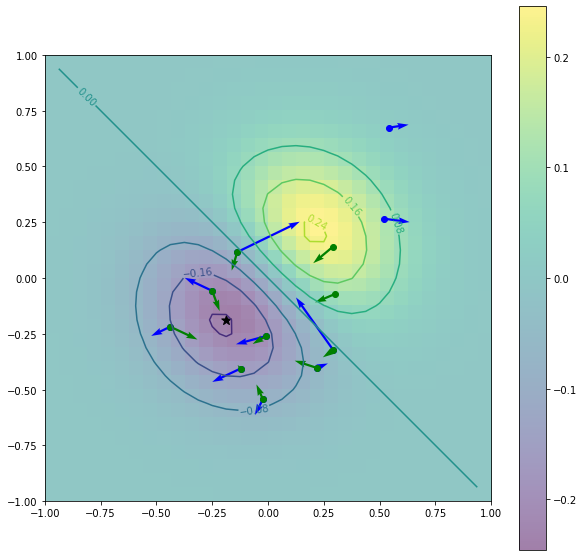

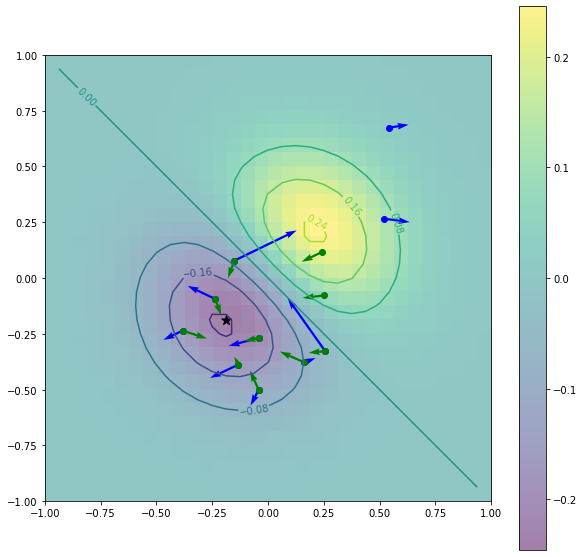

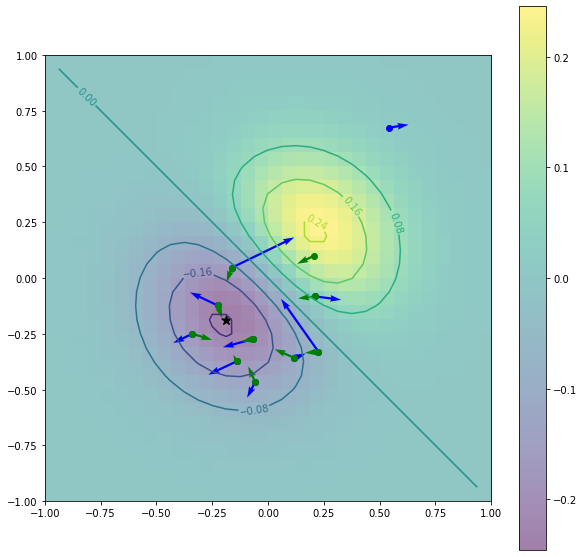

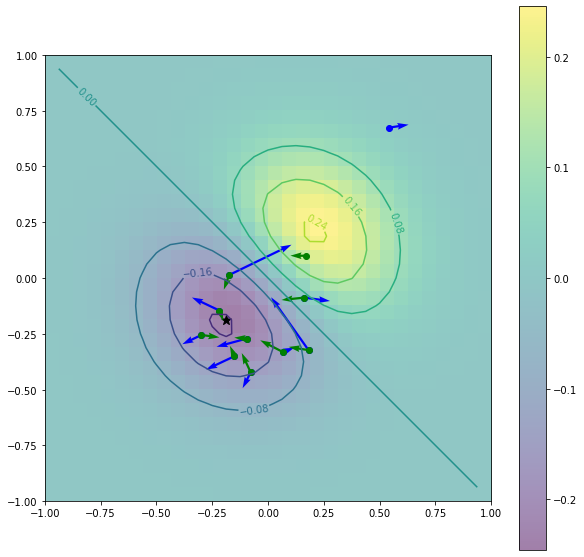

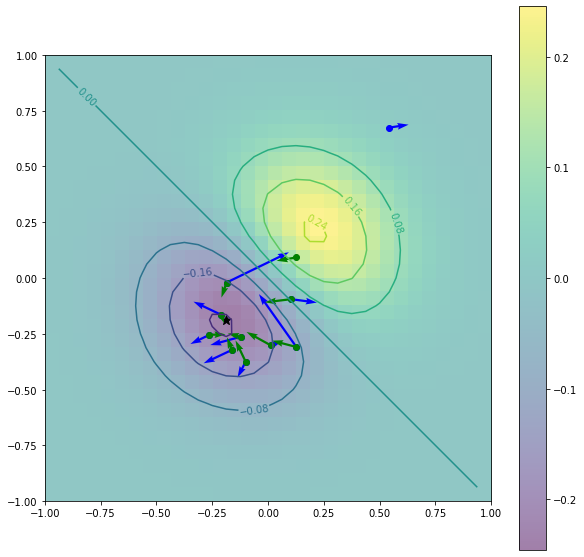

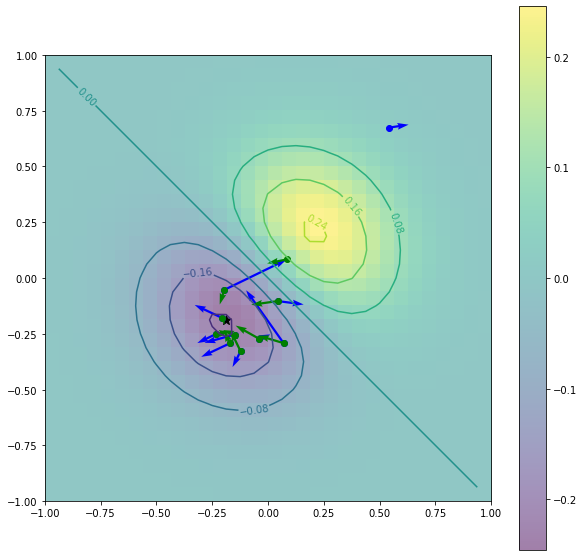

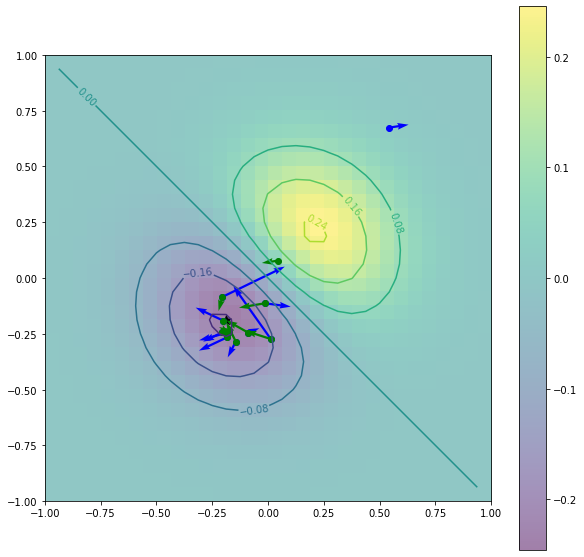

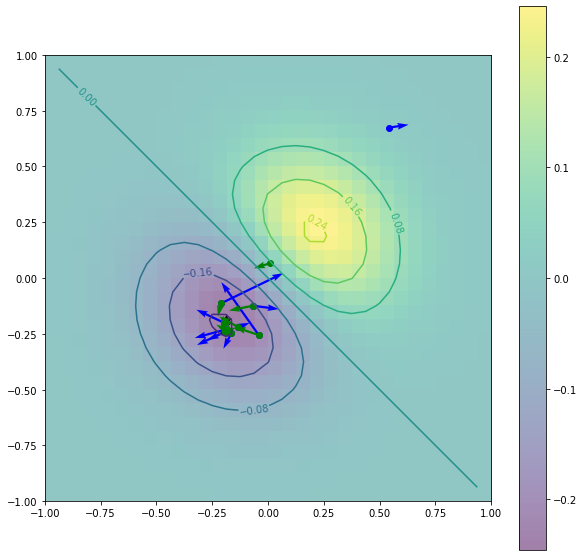

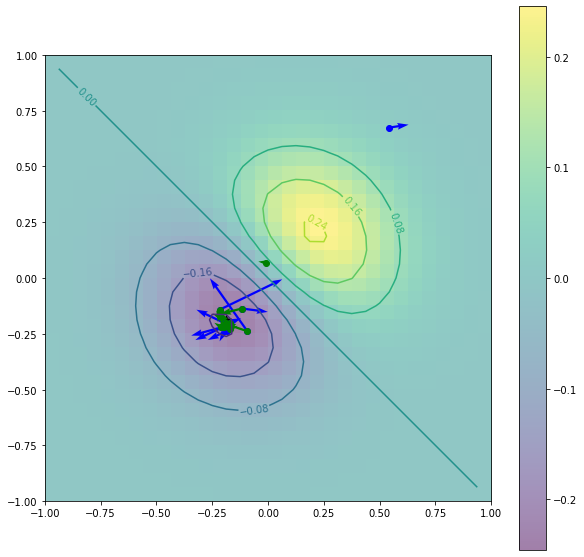

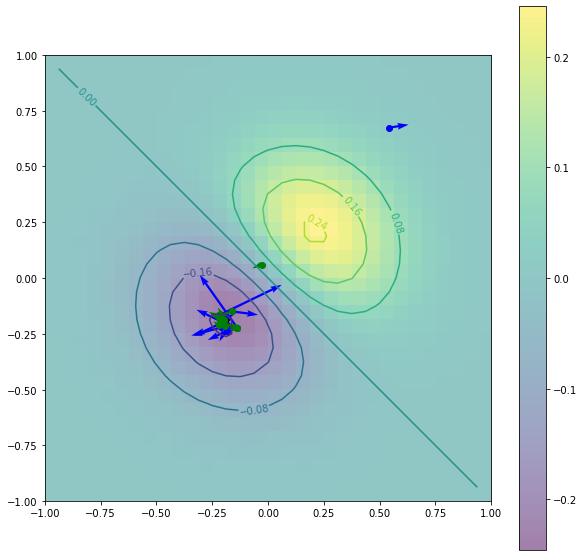

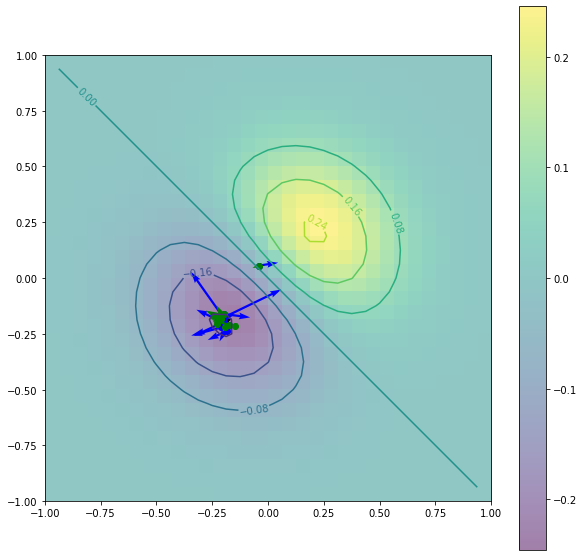

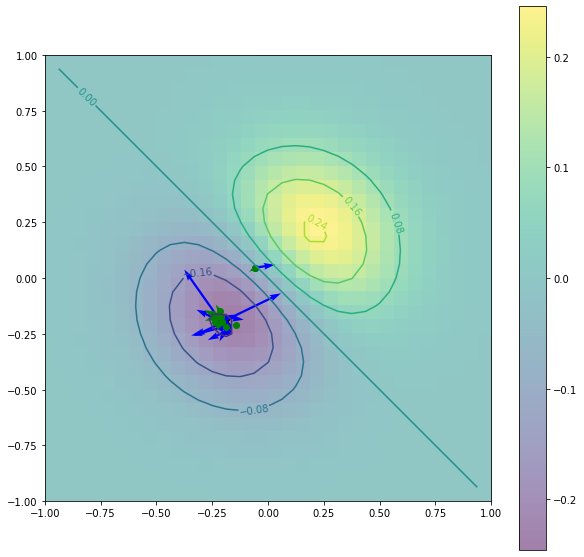

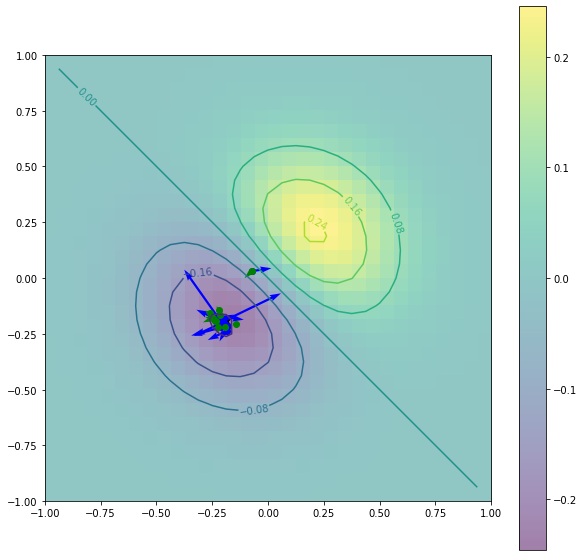

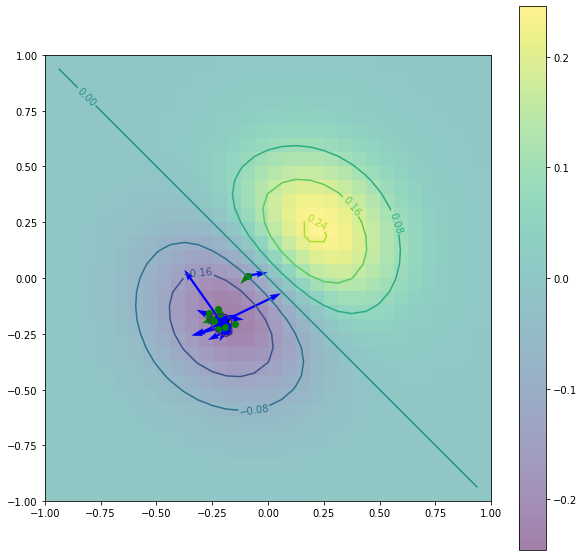

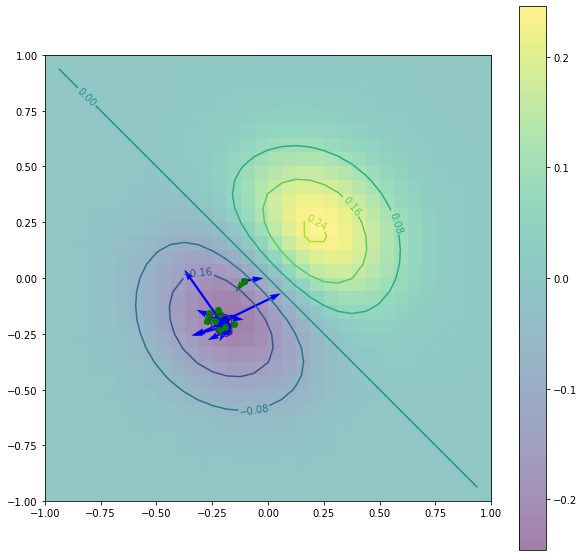

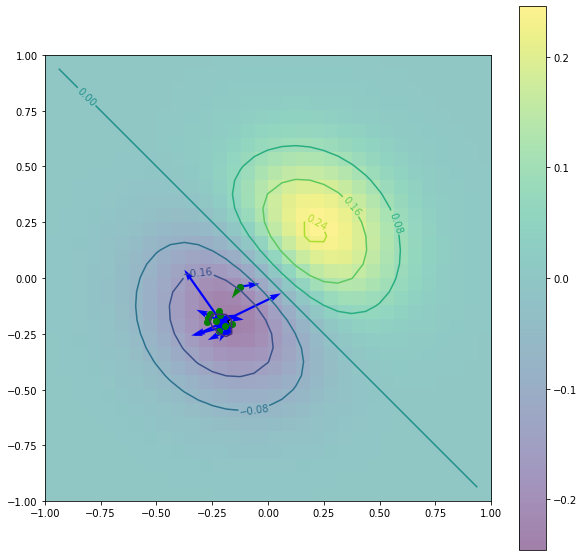

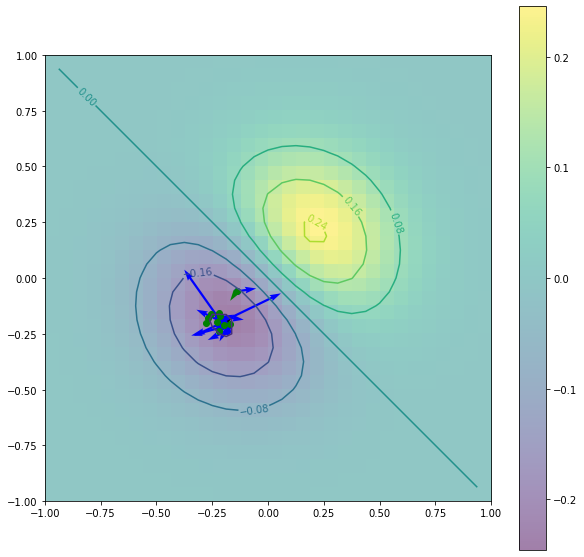

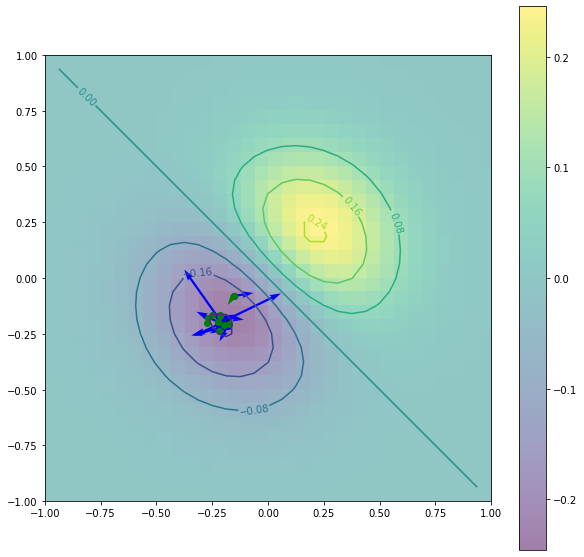

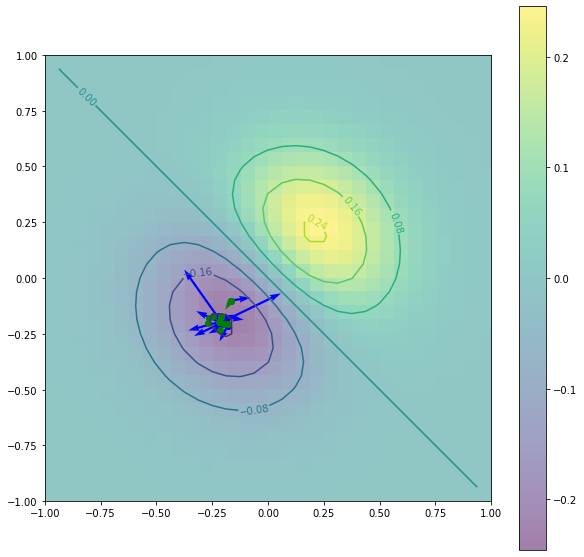

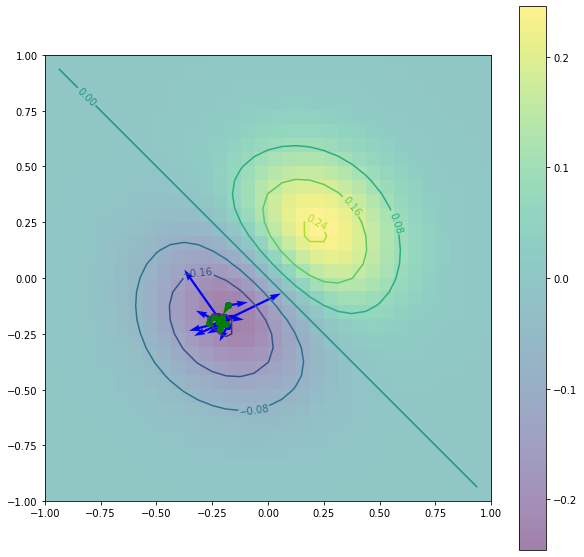

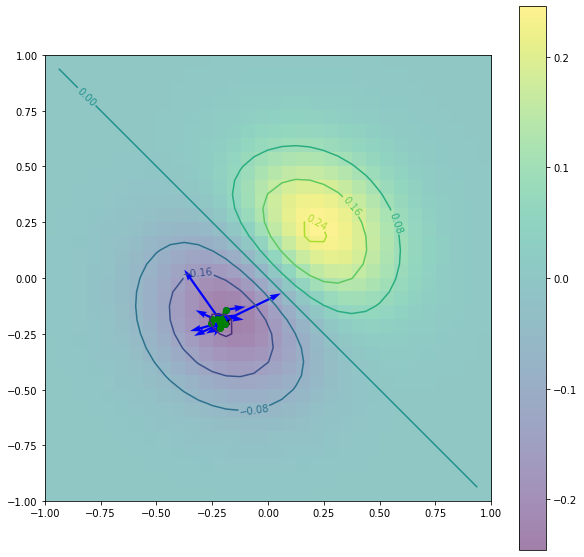

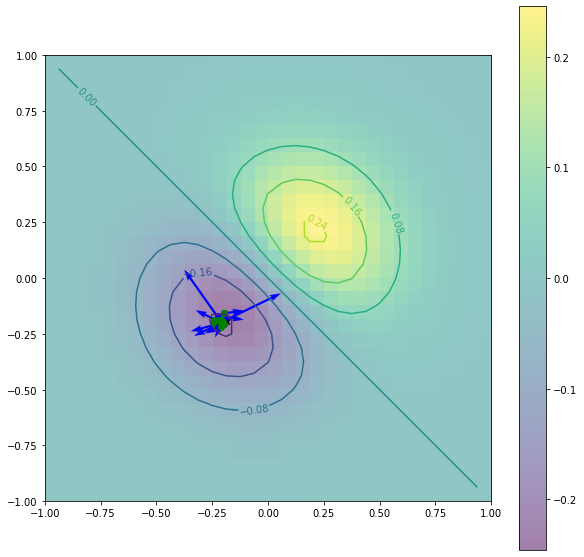

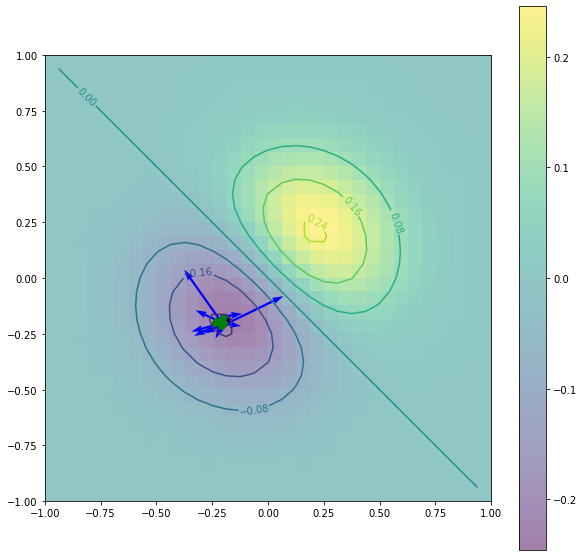

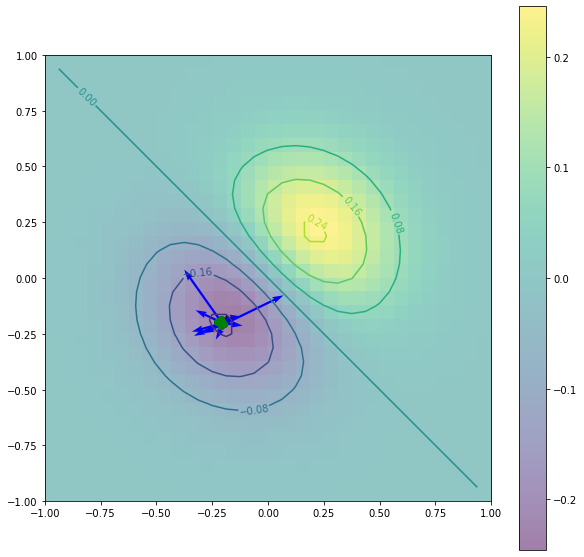

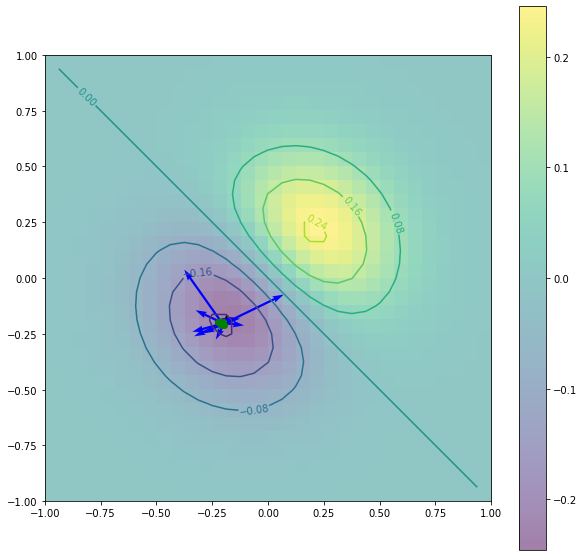

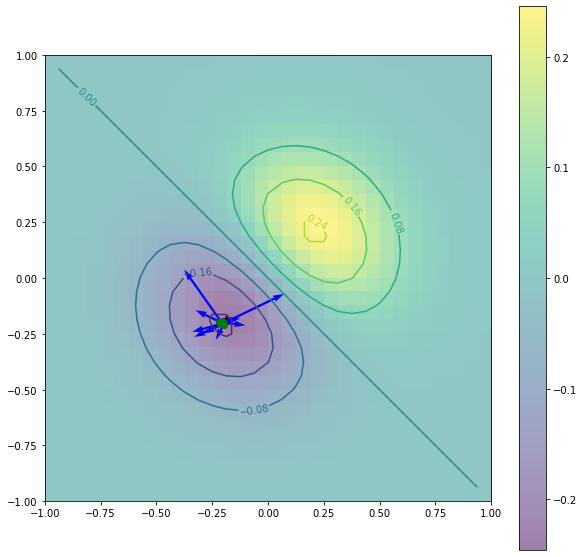

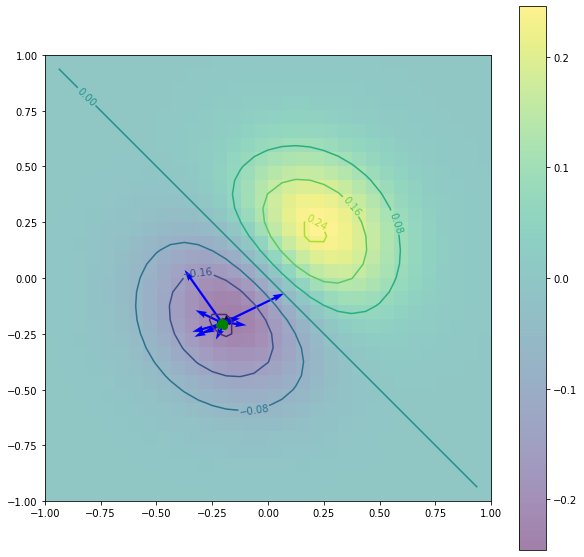

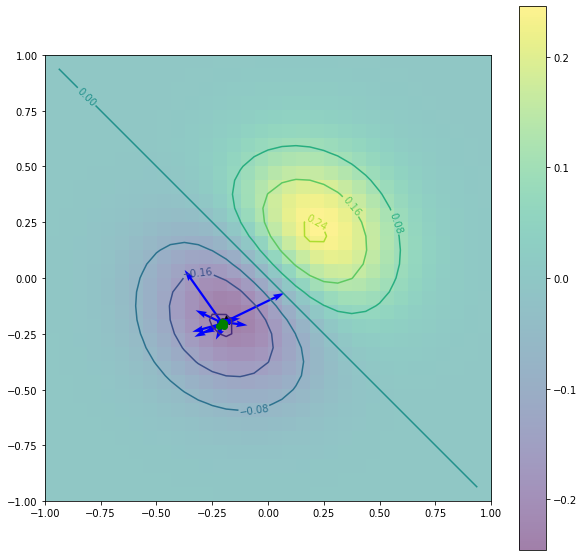

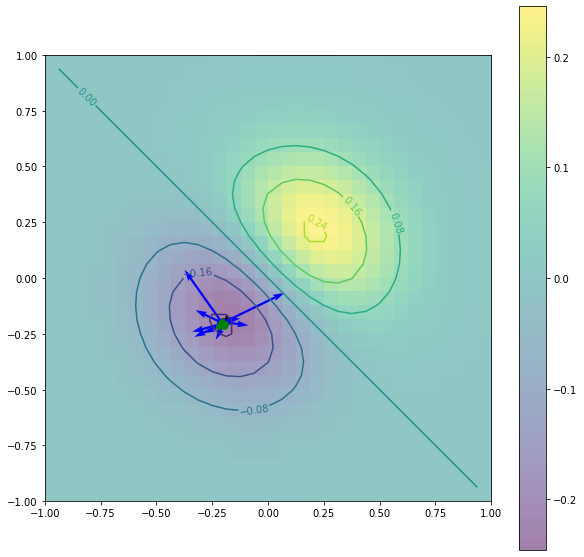

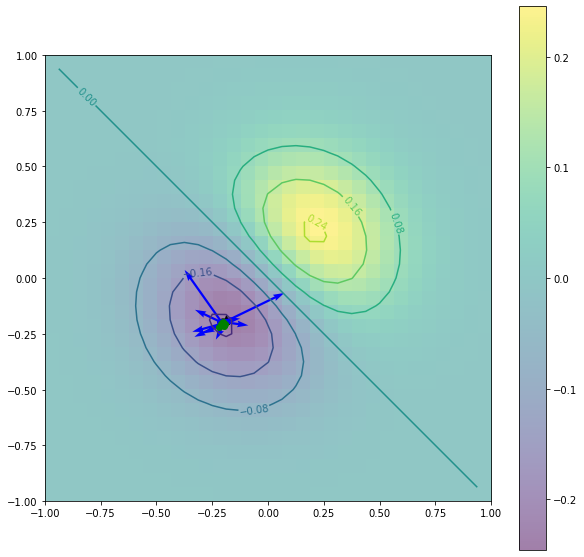

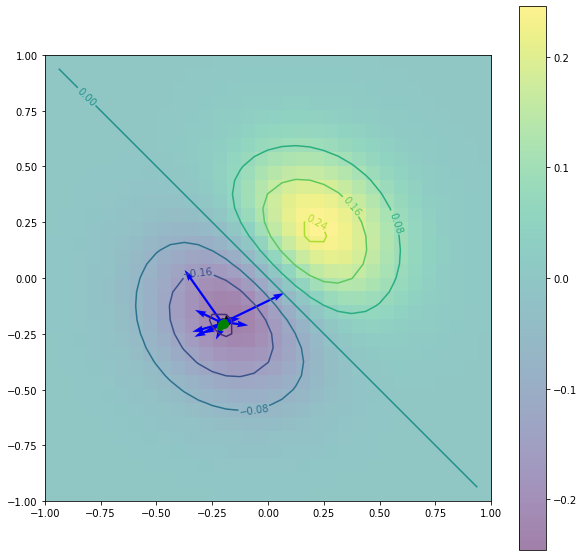

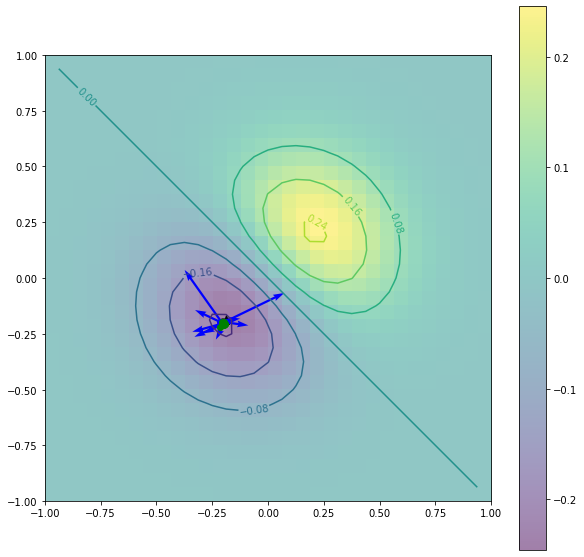

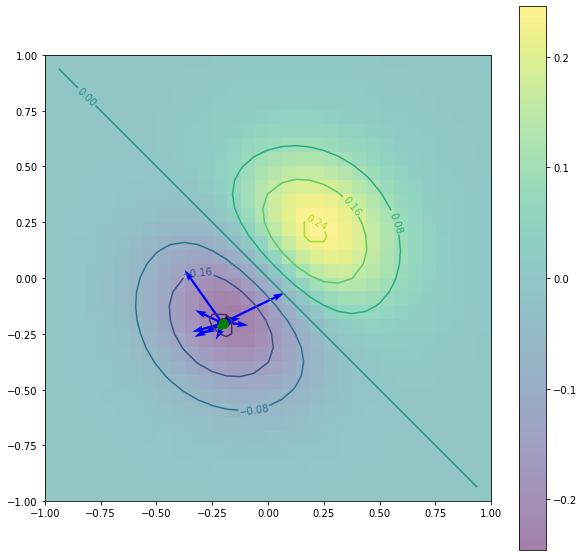

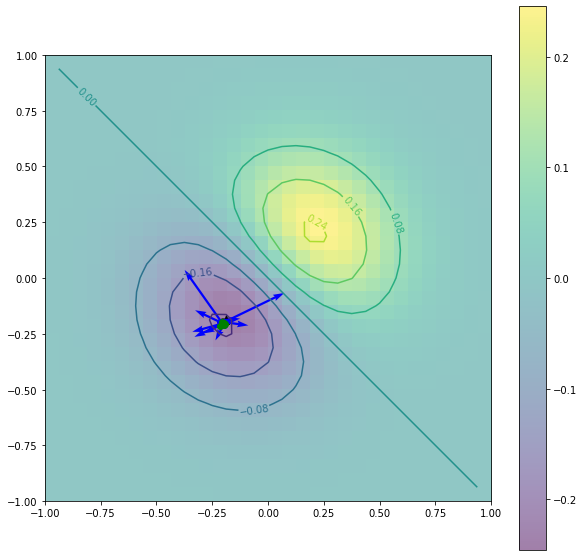

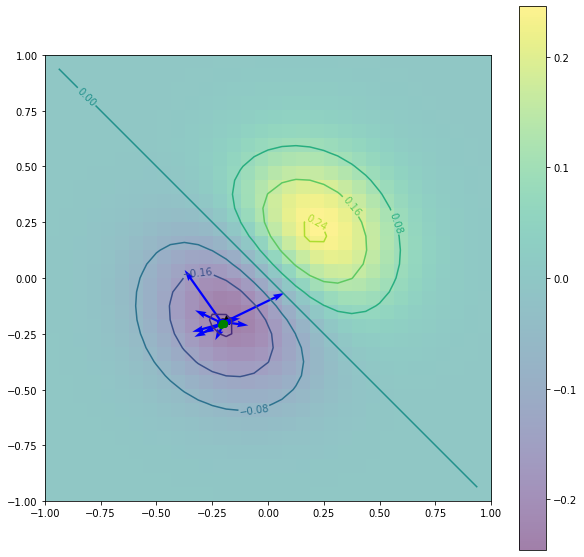

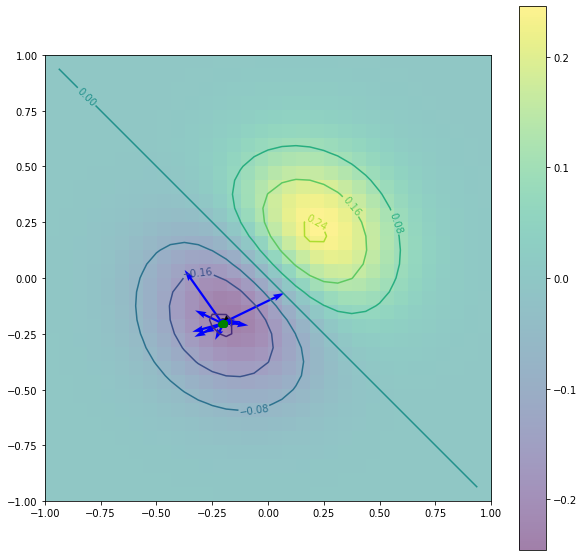

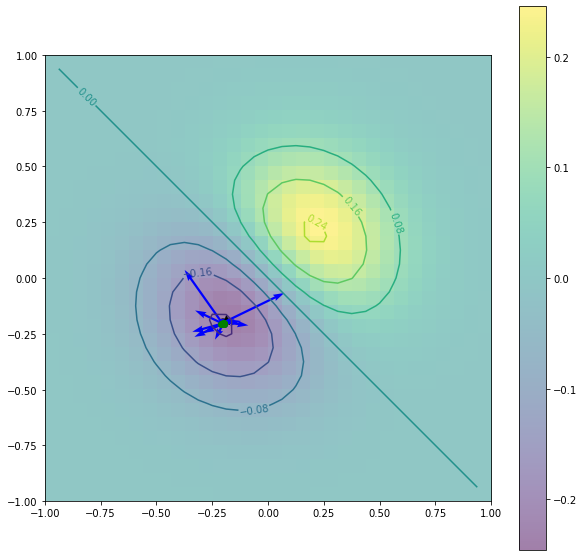

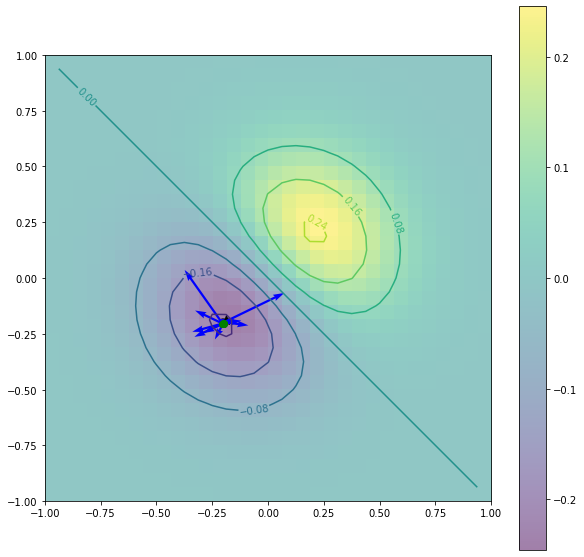

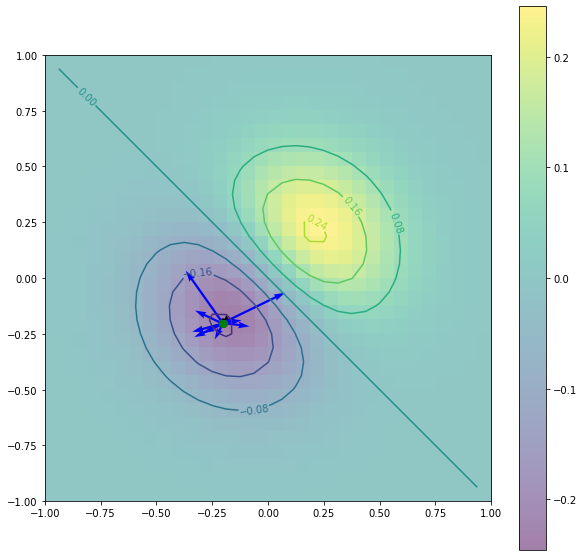

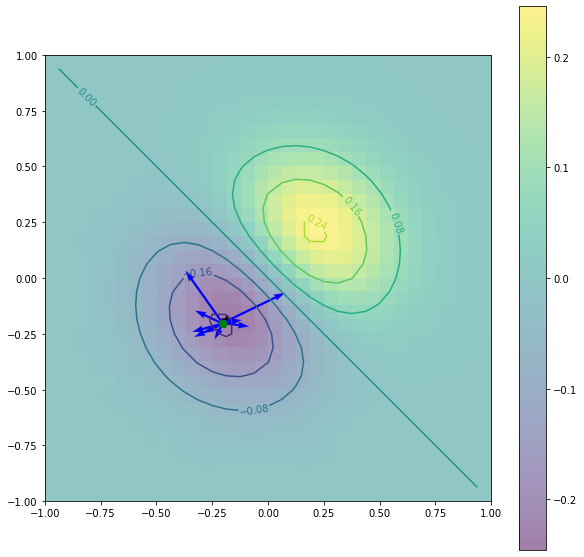

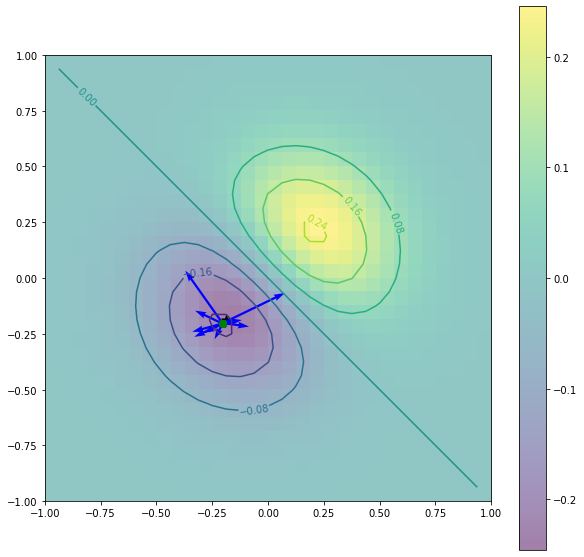

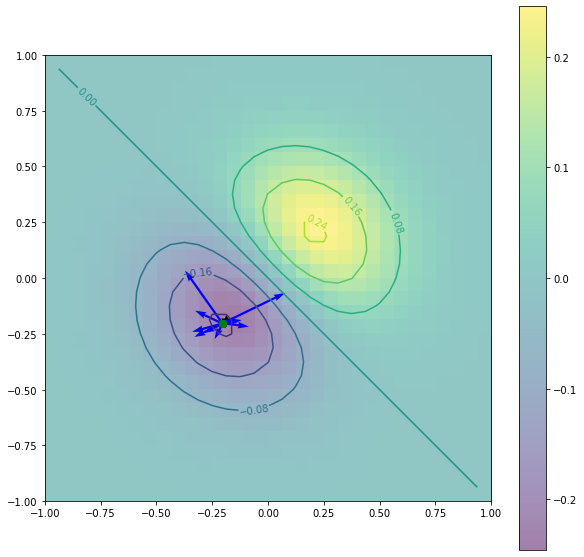

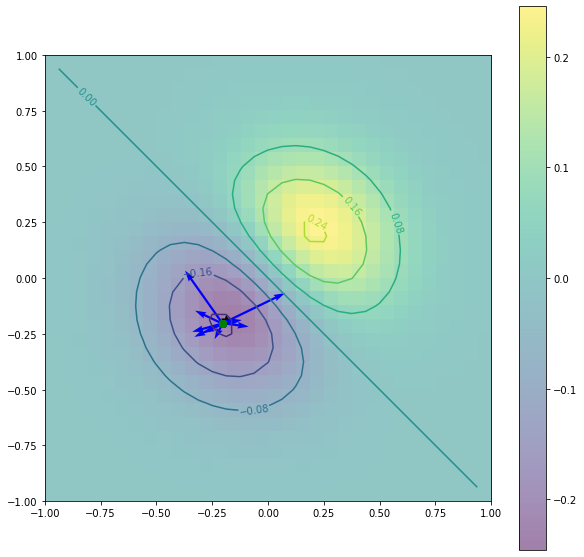

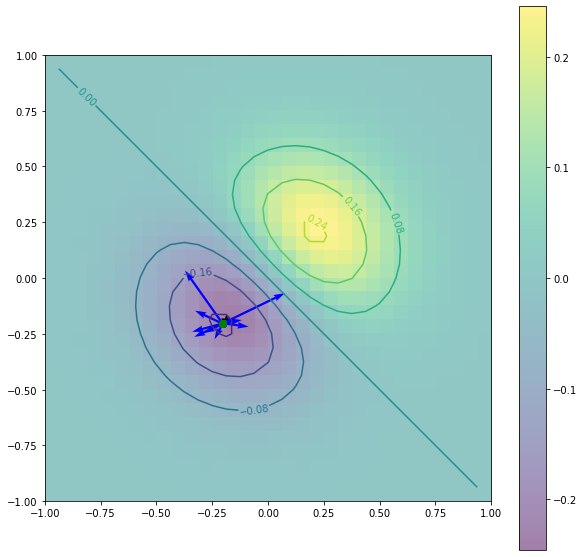

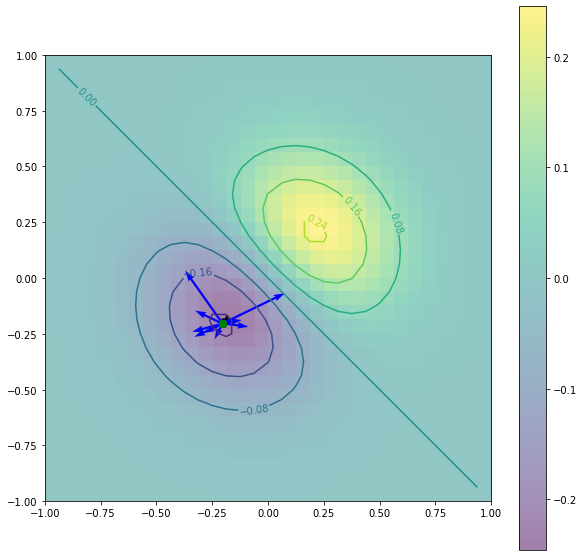

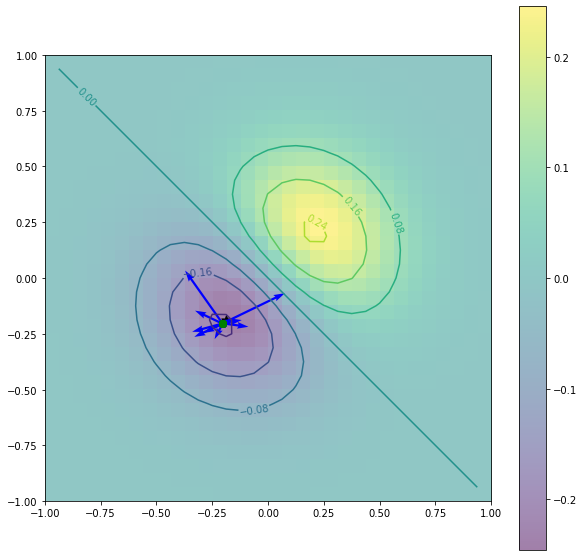

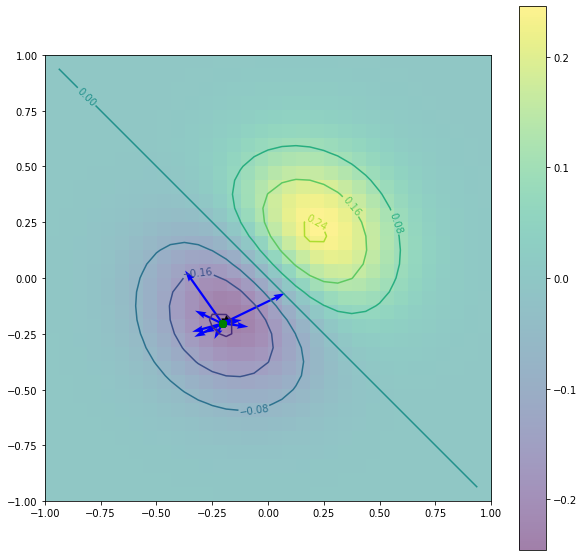

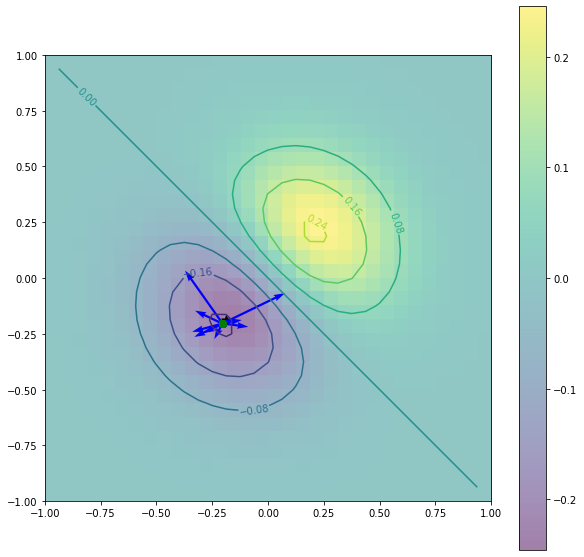

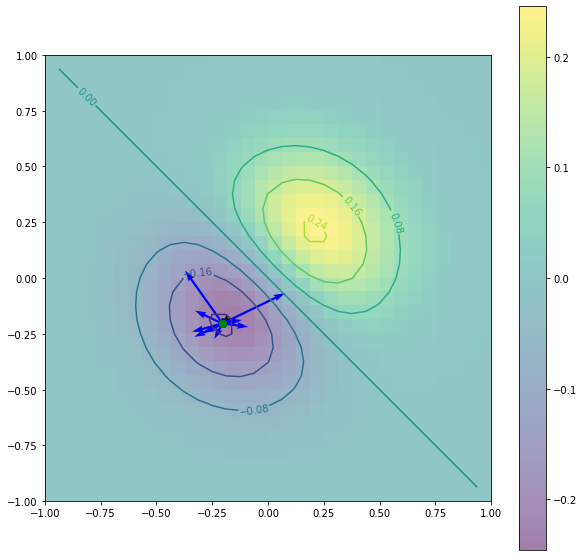

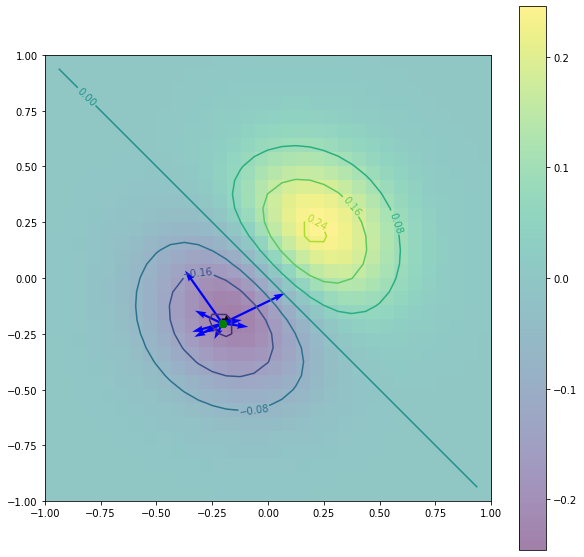

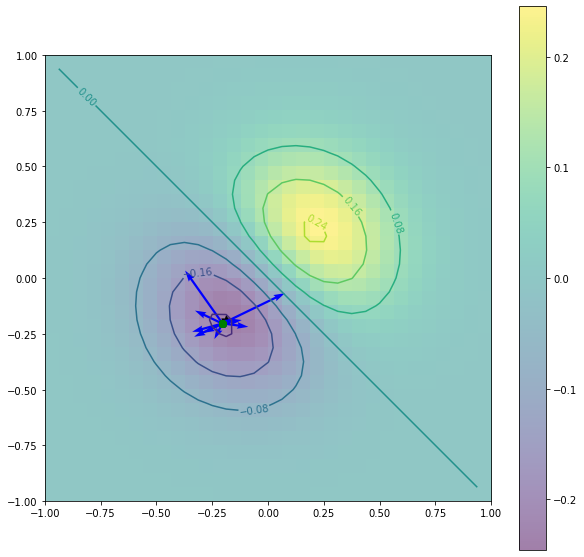

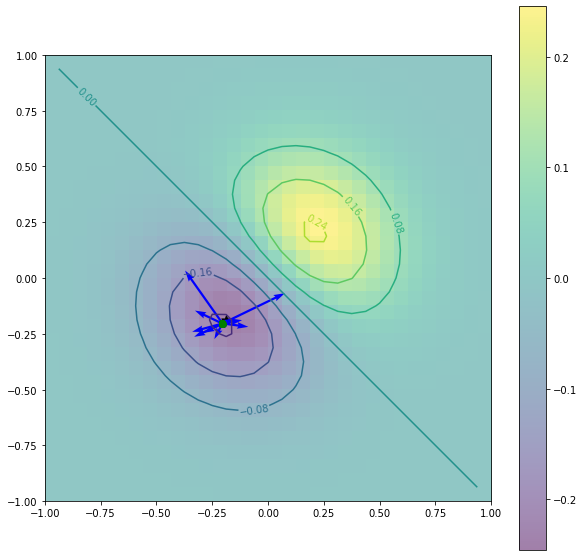

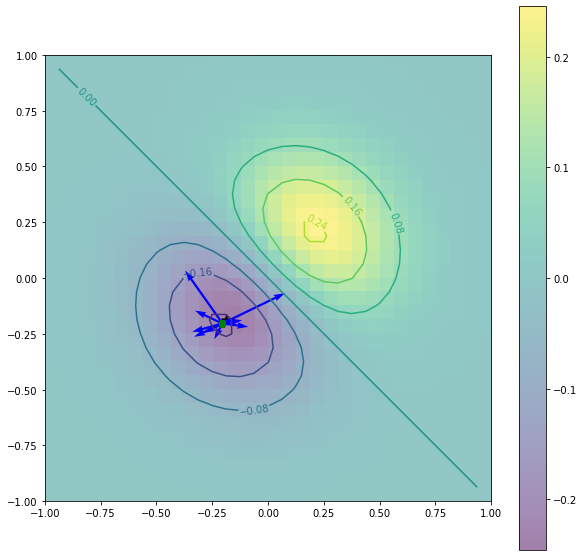

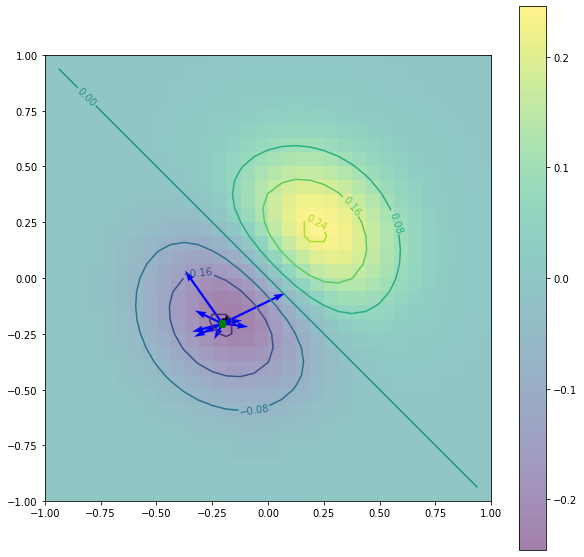

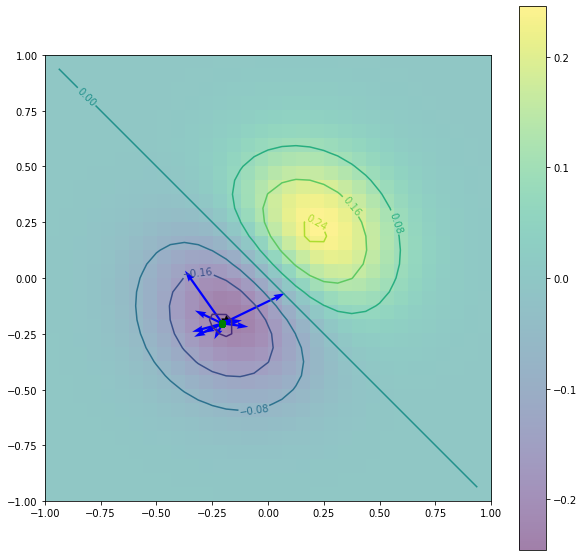

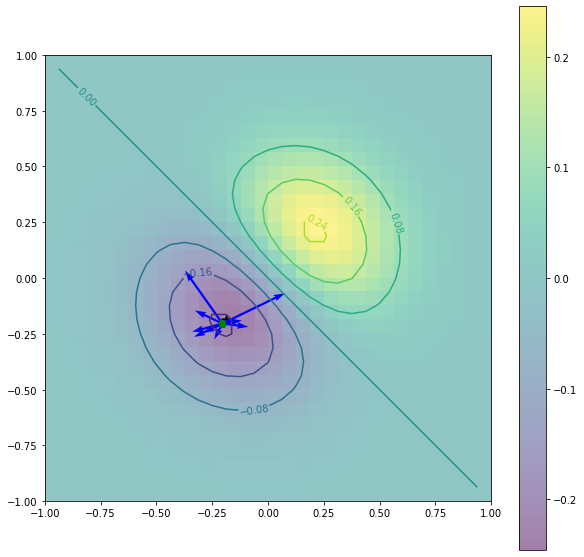

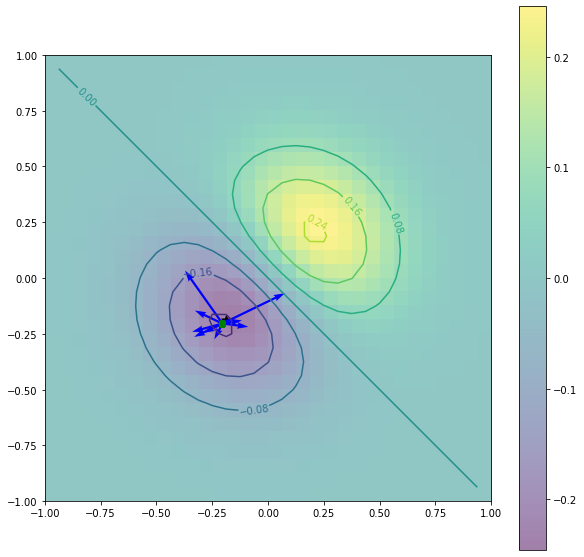

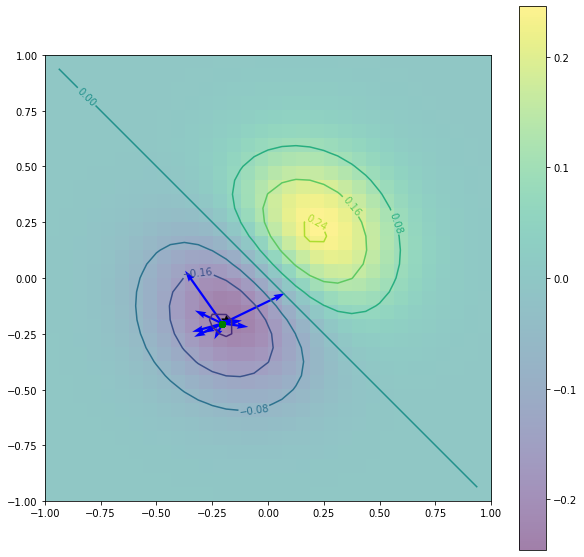

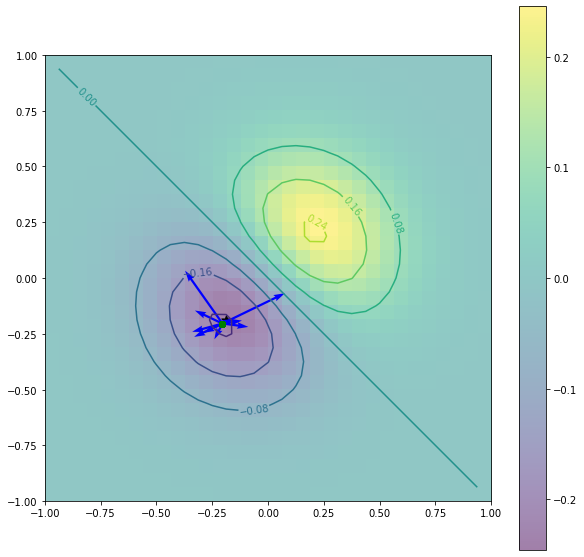

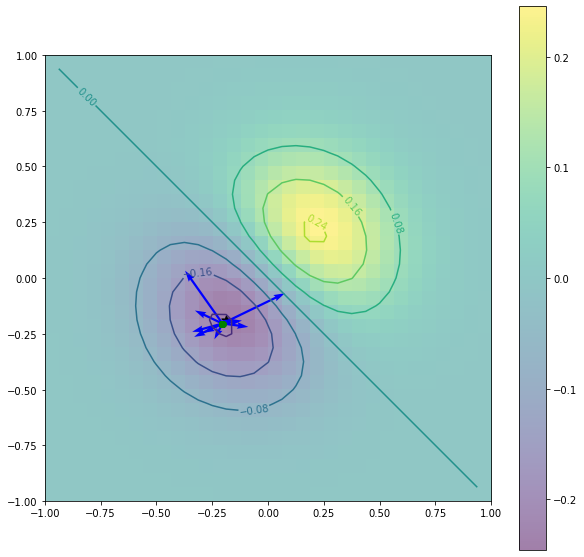

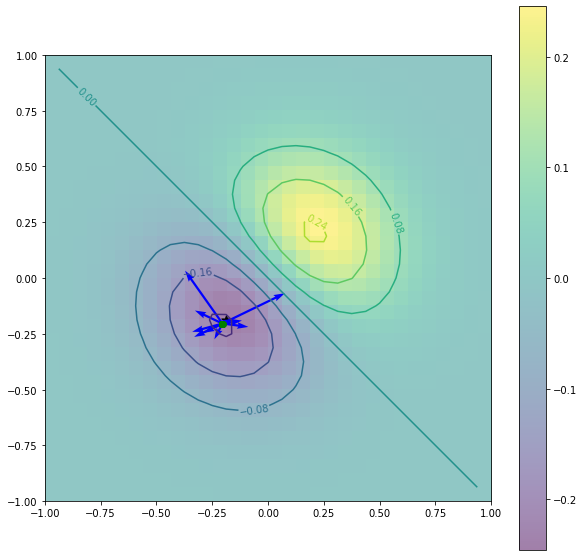

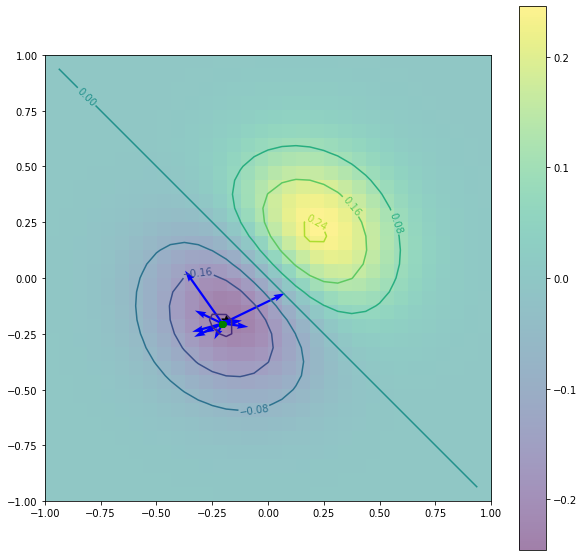

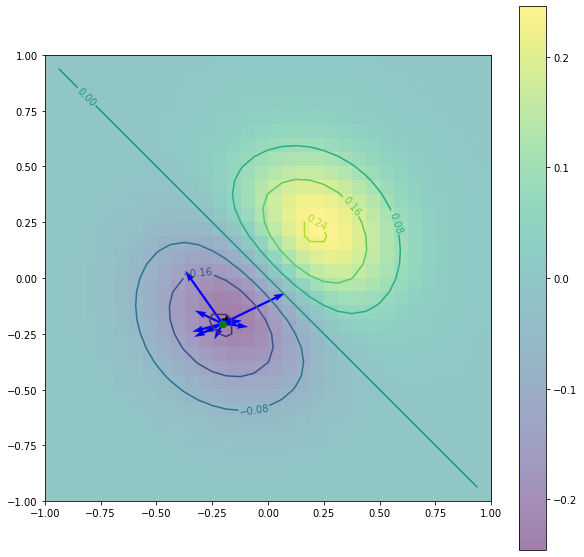

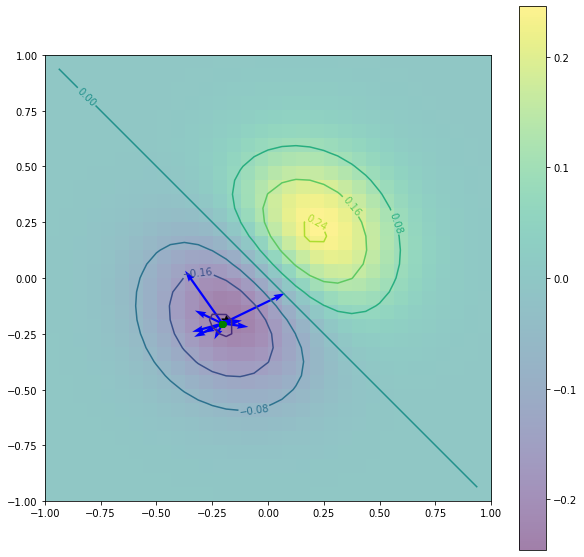

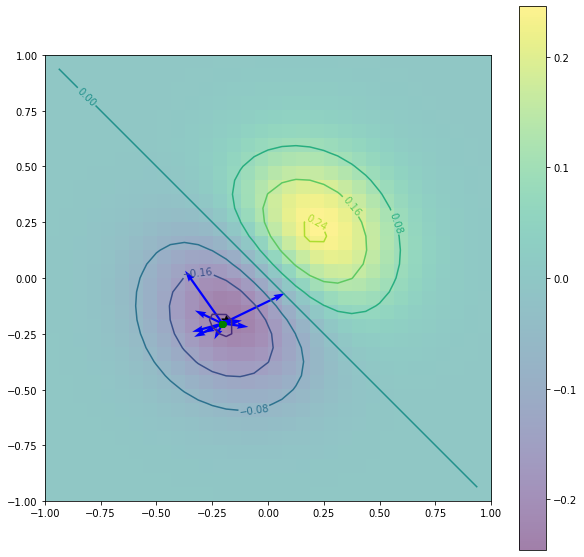

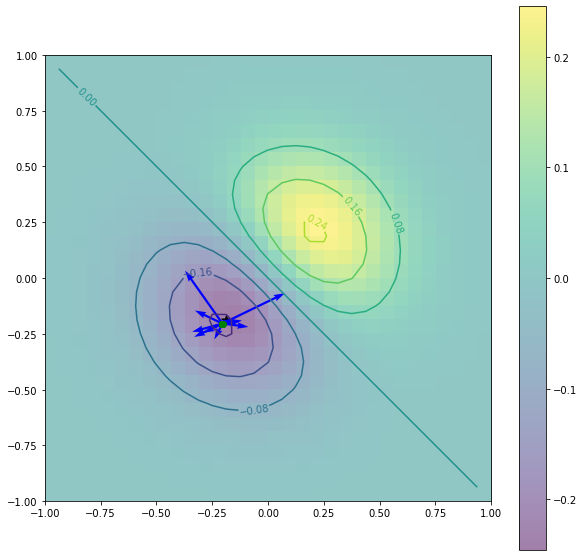

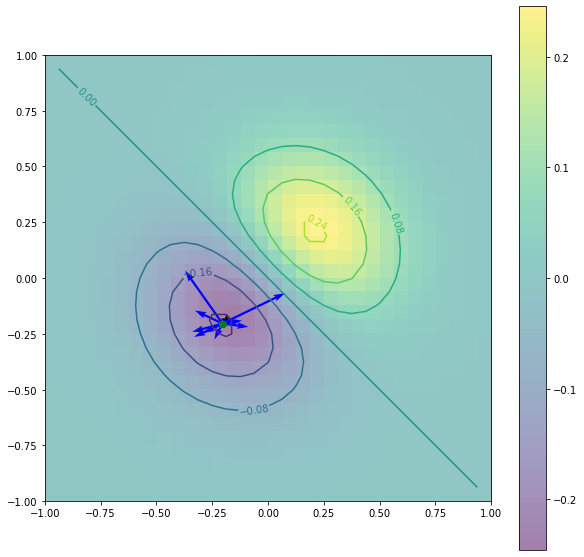

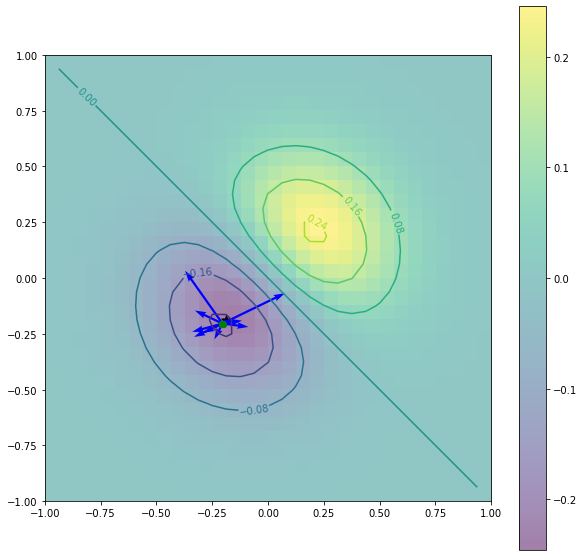

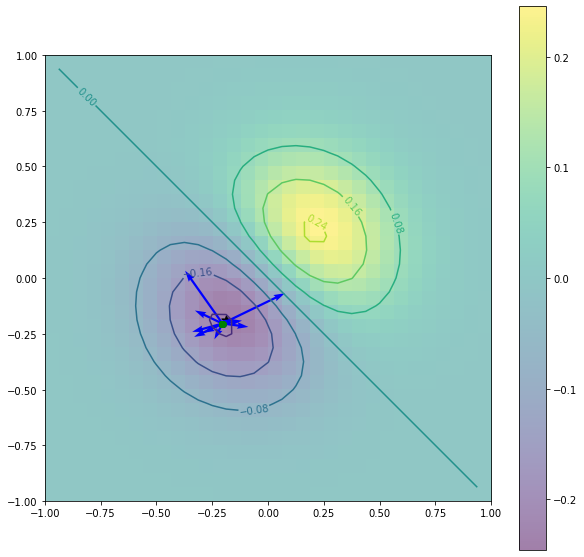

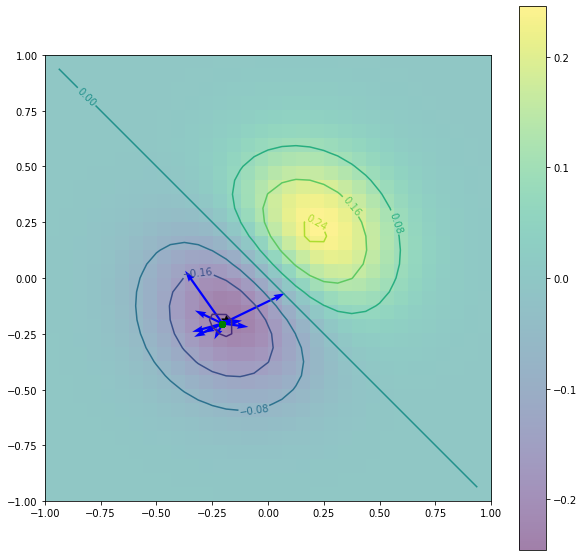

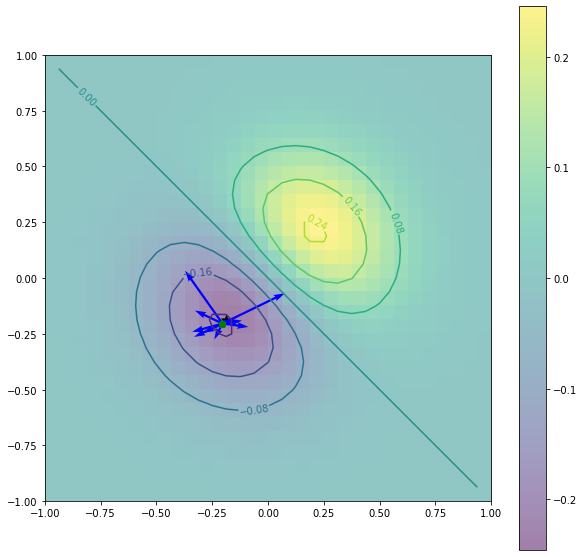

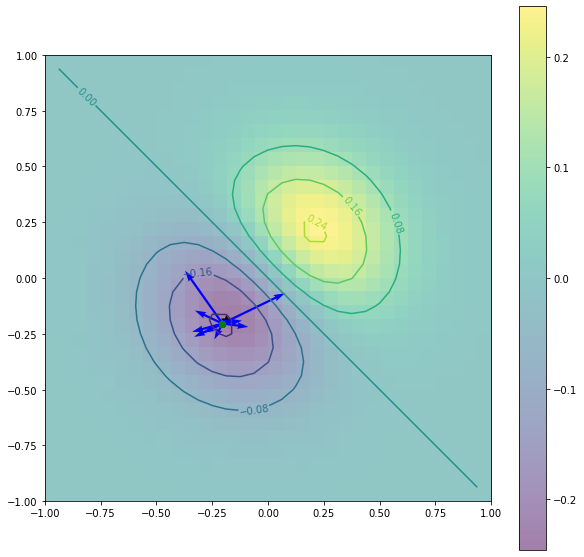

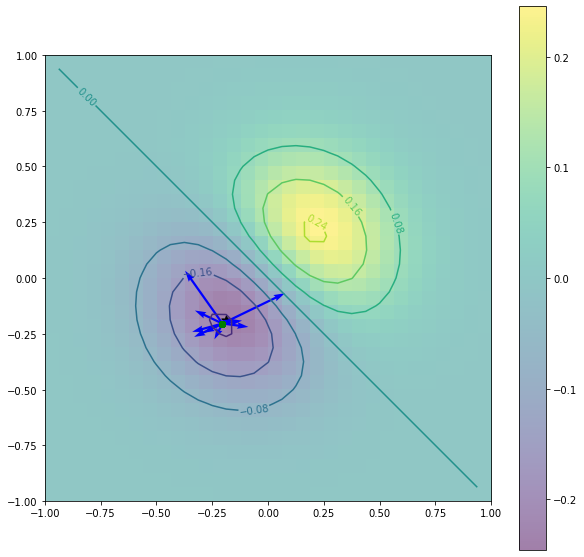

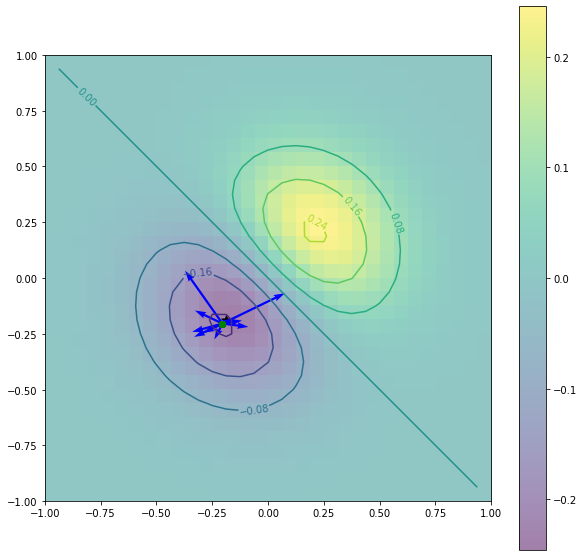

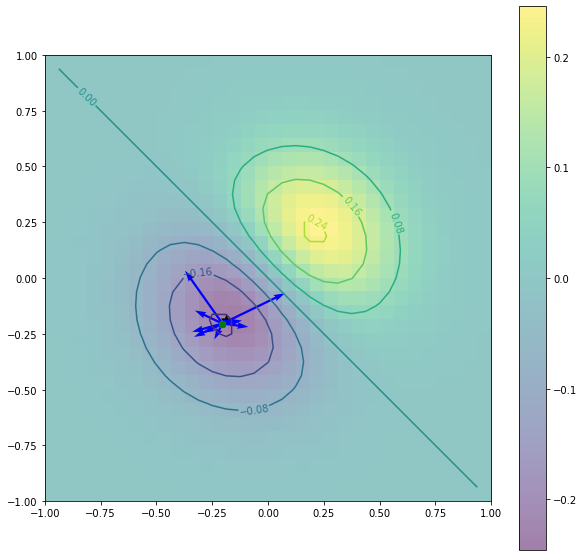

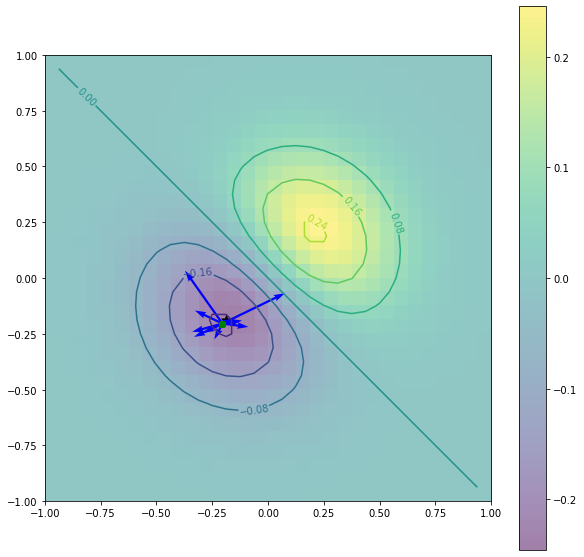

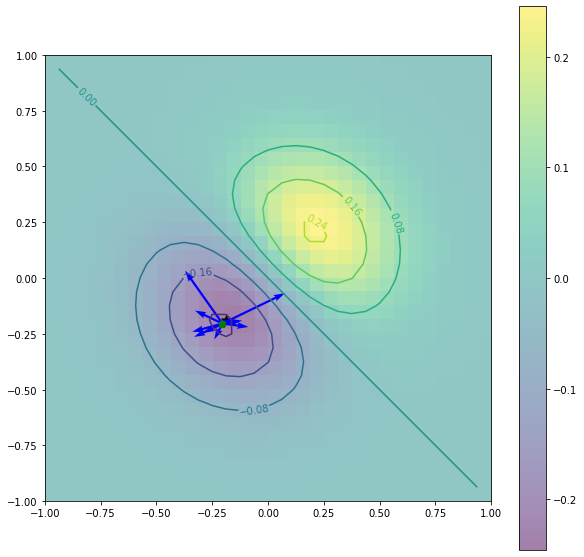

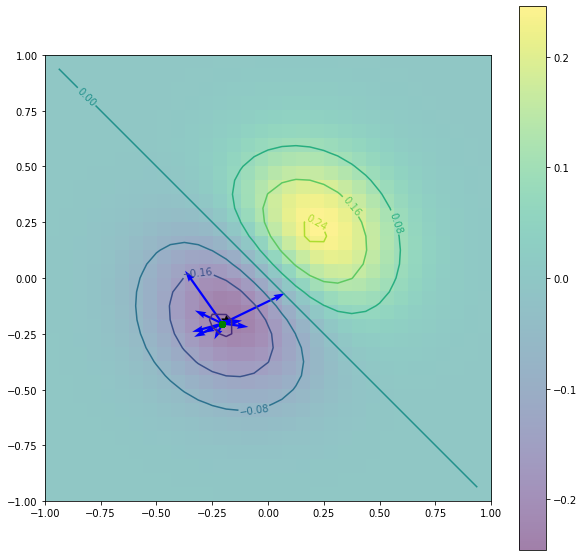

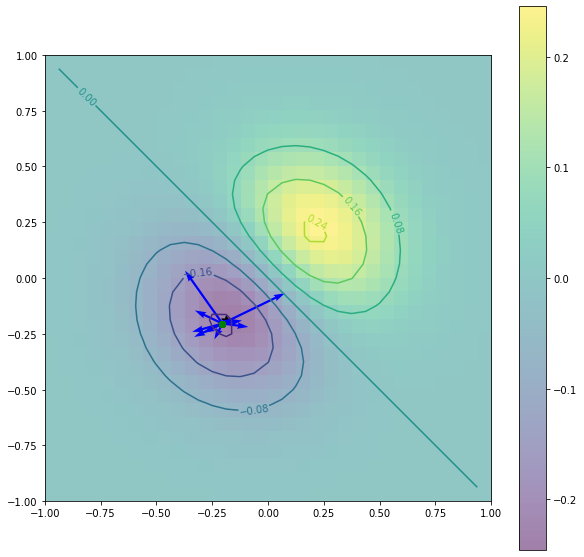

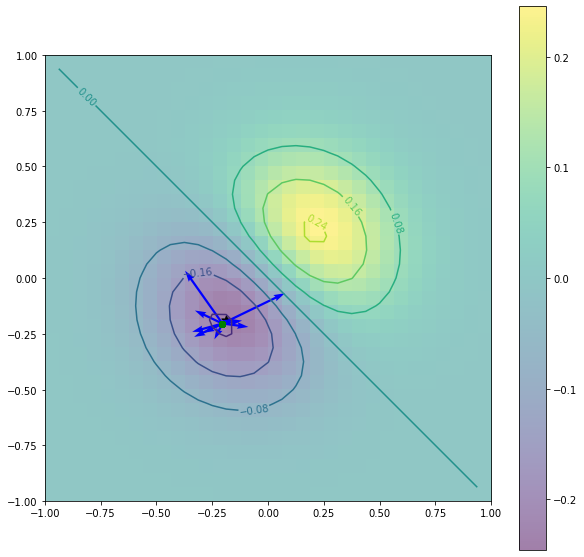

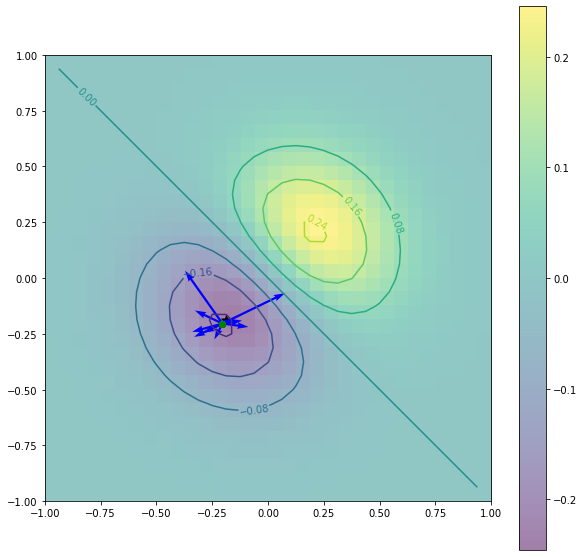

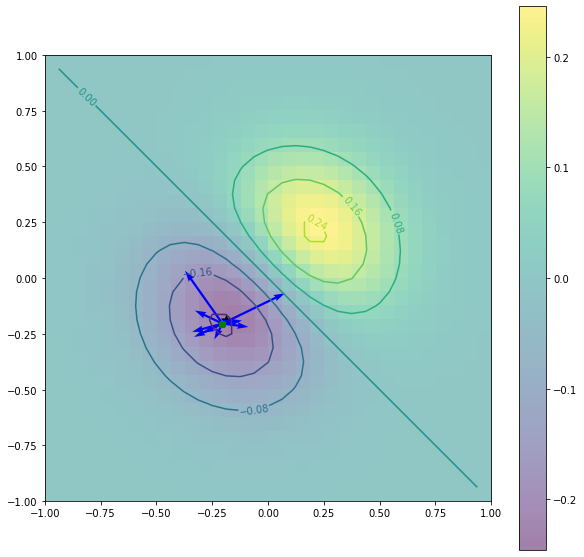

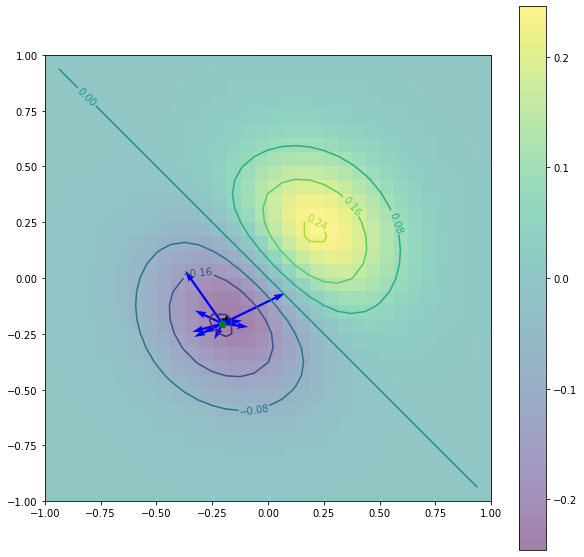

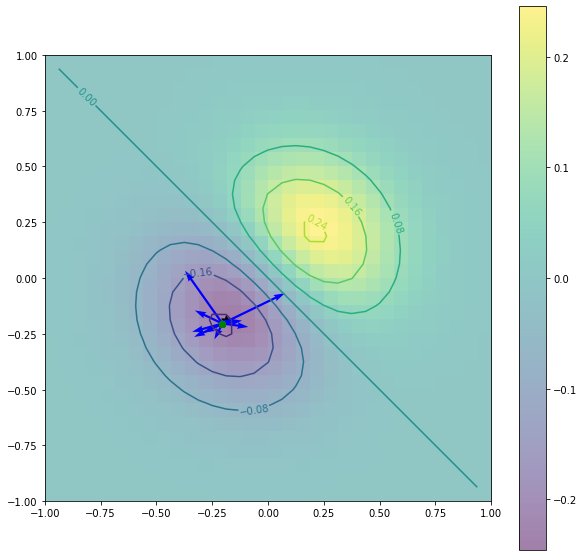

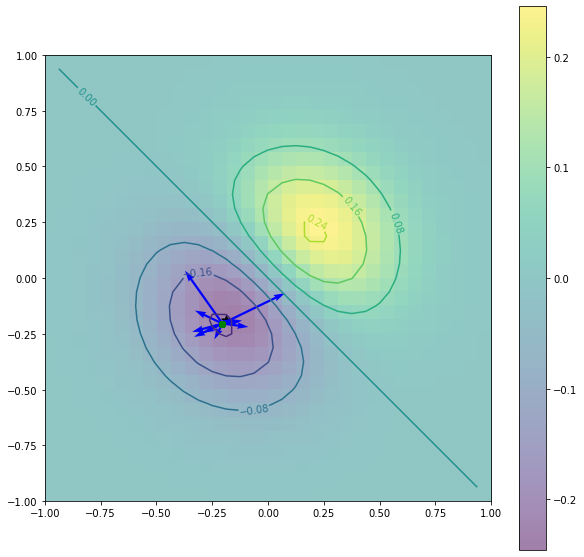

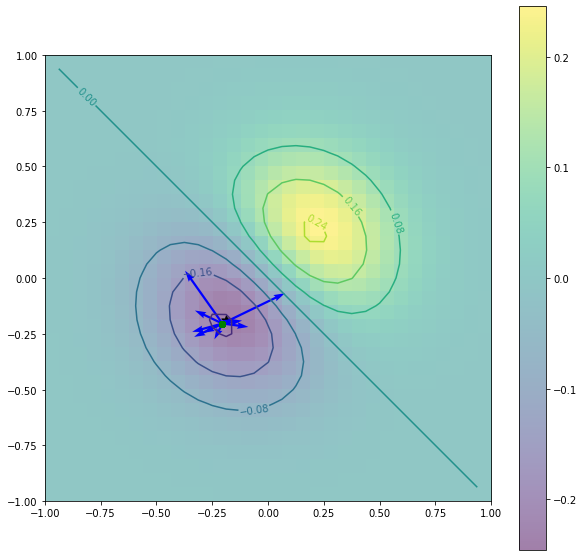

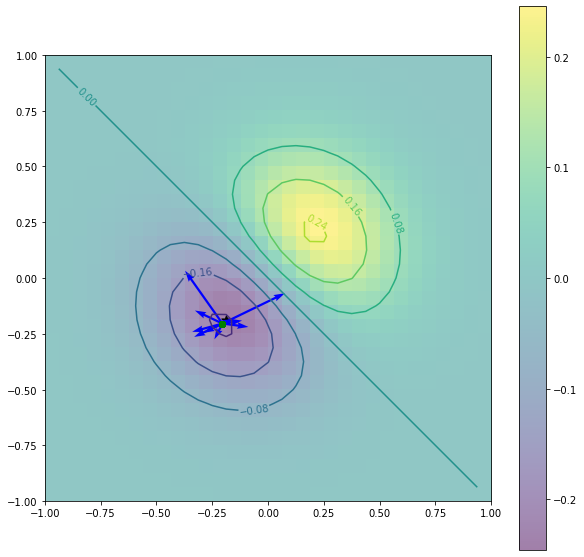

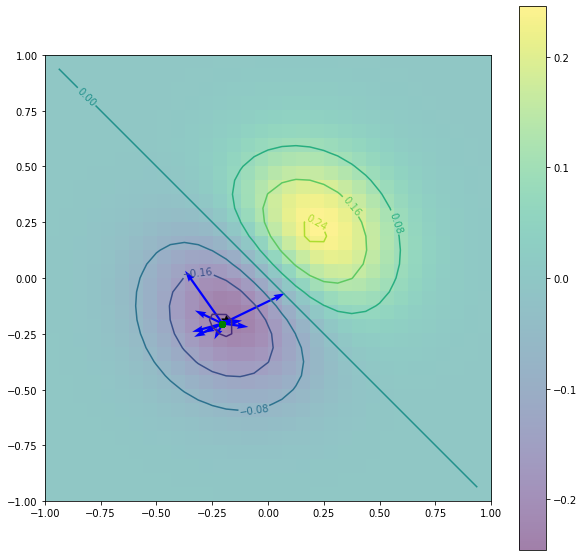

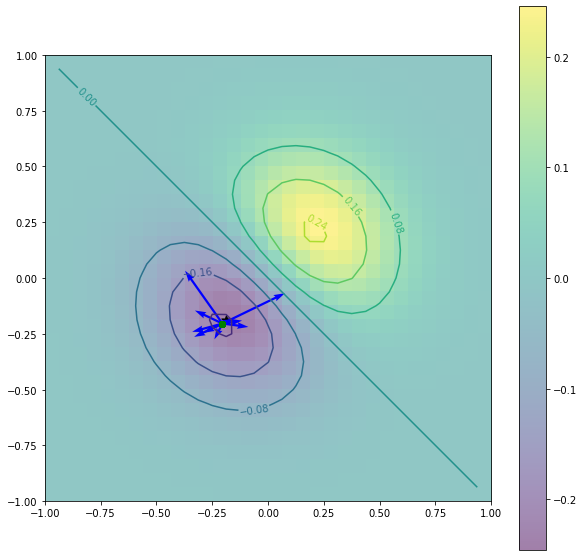

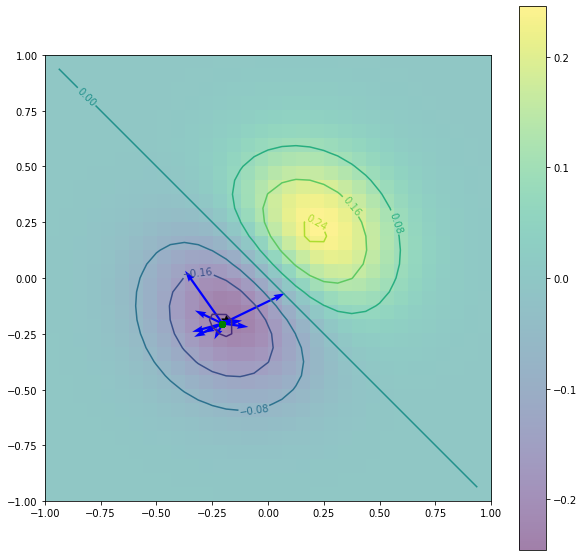

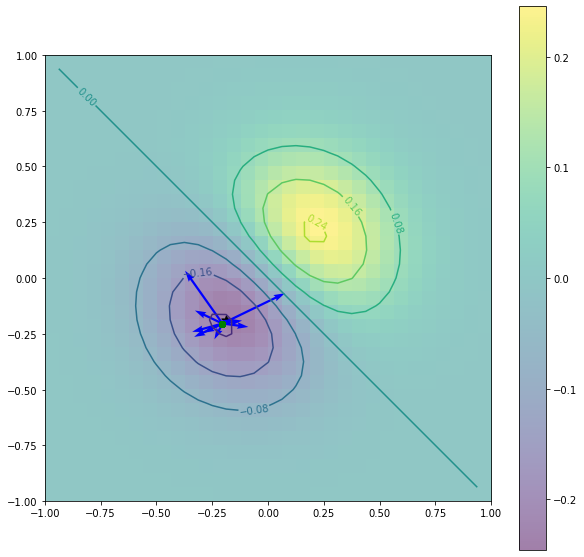

In [35]:
NP = 10
v = 0.1
dt = 0.5
uP0 = np.random.uniform(-search_area_scale/2,search_area_scale/2.,size=(NP,2)) + search_area_center
vP0 = v*np.random.randn(NP,2)

particle_best = uP0
particle_best_objective = objective_function(uP0[:,0],uP0[:,1])
global_best = particle_best[particle_best_objective.argmin()]
global_best_objective = particle_best_objective.min()

c1 = c2 = 0.1
w = 0.8

uP = np.copy(uP0)
vP = np.copy(vP0)
for _ in range(100):
    r = np.random.rand(2)
    vP = w * vP + c1*r[0]*(particle_best - uP) + c2*r[1]*(global_best-uP)
    uP = uP + vP*dt
    
    objective = objective_function(uP[:,0], uP[:,1])
    particle_best[objective <= particle_best_objective] = uP[objective <= particle_best_objective]
    particle_best_objective = np.array([particle_best_objective, objective]).min(axis=0)
    global_best = particle_best[particle_best_objective.argmin()]
    global_best_objective = particle_best_objective.min()

    fig, ax = plt.subplots(figsize=(10,10))
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
    plt.imshow(Z, extent=[search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2], origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.scatter([X_min],[Y_min],marker='*',c='k',s=100)
    plt.scatter(*(zip(*uP0)),c='blue')
    plt.quiver(*(zip(*uP0)),*(zip(*vP0)) , color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)

    plt.scatter(*(zip(*uP)),c='green')
    plt.quiver(*(zip(*uP)),*(zip(*vP)) , color='green', width=0.005, angles='xy', scale_units='xy', scale=1)
    plt.show()

    

In [57]:
def get_minimum_PSO(objective_function,search_area_center, search_area_scale, NP, v, dt, c1=0.1, c2=0.1, w=0.8, generate_plots=True, eps = 0.01, N_iterations=100):
    # https://www.cs.tufts.edu/comp/150GA/homeworks/hw3/_reading6%201995%20particle%20swarming.pdf
    """
     Estimates minimum value and the arguments for a continuous non-linear function using the particle swarming 
     optimization algorithm.
     Reference: https://www.cs.tufts.edu/comp/150GA/homeworks/hw3/_reading6%201995%20particle%20swarming.pdf
                https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/ 

     Parameters:
     objective_function: object
         funtion to be minimized. It should be a numpy function.
     search_area_center: array
         center of the (square) area of interest
     search_area_scale: scalar
         length of the (square) area of interest
     NP: scalar
         number of particles
     v, dt: scalars
         velocity and delta t. It can be combined into vdt
     c1,c2,w: scalars
         PSO parameters (TODO: explore meaning and further details)
     generate_plots: boolean
         True: generates the plots for each iteration (very slow)
         False: produces only the min and the argument (faster)
     N_iterations: scalar
        number of iterations
     eps: scalar
         tolerance to change in the best value (TODO: improve early stopping)
         
     Returns:
     global_best_objective:  scalar
         minimum value of teh objective function
     global_best: array
         position of minimum value
     """     
    
    # initializing positions and speeds of particles
    uP = np.random.uniform(-search_area_scale/2,search_area_scale/2.,size=(NP,2)) + search_area_center
    vP = v*np.random.randn(NP,2)
    # computing initial particle and global best values
    particle_best = uP
    particle_best_objective = objective_function(uP[:,0],uP[:,1])
    global_best = particle_best[particle_best_objective.argmin()]
    global_best_objective = particle_best_objective.min()
    
    for jj in range(N_iterations):
        # updating postions and speeds of particles
        r = np.random.rand(2)
        vP = w * vP + c1*r[0]*(particle_best - uP) + c2*r[1]*(global_best-uP)
        uP = uP + vP*dt

        # updating particle and global best values 
        objective = objective_function(uP[:,0], uP[:,1])
        particle_best[objective <= particle_best_objective] = uP[objective <= particle_best_objective]
        particle_best_objective = np.array([particle_best_objective, objective]).min(axis=0)
        #global_best = particle_best[particle_best_objective.argmin()]
        if np.abs(global_best_objective-particle_best_objective.min()) < eps:
            print("Early Stop at " + str(jj) + " iterations")
            return(global_best_objective, global_best)
        else:
            global_best_objective = particle_best_objective.min()

        if generate_plots == True:
            fig, ax = plt.subplots(figsize=(10,10))
            CS = ax.contour(X, Y, Z)
            ax.clabel(CS, inline=True, fontsize=10)
            plt.imshow(Z, extent=[search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2], origin='lower', cmap='viridis', alpha=0.5)
            plt.colorbar()
            plt.scatter([X_min],[Y_min],marker='*',c='k',s=100)
            plt.scatter(*(zip(*uP)),c='green')
            plt.quiver(*(zip(*uP)),*(zip(*vP)) , color='green', width=0.005, angles='xy', scale_units='xy', scale=1)
            plt.show()
    if generate_plots == False:
        fig, ax = plt.subplots(figsize=(10,10))
        CS = ax.contour(X, Y, Z)
        ax.clabel(CS, inline=True, fontsize=10)
        plt.imshow(Z, extent=[search_area_center[0]-search_area_scale/2,search_area_center[0]+search_area_scale/2,search_area_center[1]-search_area_scale/2,search_area_center[1]+search_area_scale/2], origin='lower', cmap='viridis', alpha=0.5)
        plt.colorbar()
        plt.scatter([X_min],[Y_min],marker='*',c='k',s=100)
        plt.scatter(*(zip(*uP)),c='green')
        plt.quiver(*(zip(*uP)),*(zip(*vP)) , color='green', width=0.005, angles='xy', scale_units='xy', scale=1)
        plt.show()
    
    return(global_best_objective, global_best)
    

In [77]:
get_minimum_PSO(objective_function,search_area_center, search_area_scale, NP, v, dt, c1=0.1, c2=0.1, w=0.8, generate_plots=False, eps=0.00001, N_iterations=100)

Early Stop at 6 iterations


(-0.1436128578932219, array([-0.03168431, -0.44670749]))